# Post-fire Vegetation Recovery Analysis

Christina Appleby  
Idaho State University  
GEOL 6628  
May 5, 2023

## Introduction
The Cold Fire (Northern California) started due to lightning on June 21, 2008. This project examines how burn severity and topography affect post-fire vegetation recovery of the Cold Fire burn scar using a linear regression analysis. A random forest regression was also attempted, but the results were poor.  

## Data Sources
* Landsat ARD imagery obtained from __[USGS Earth Explorer](https://earthexplorer.usgs.gov/)__ from 2008-2022 (excluding 2012)
* Fire perimeter data from __[CALFIRE](https://frap.fire.ca.gov/mapping/gis-data/)__ for study area
* SRTM  void-filled DEM from Earth Explorer  

## Preparation  

### Python packages
I created a new environment for this project using Python version 3.11.2. If you find some of the packaged can't be installed, I recommend starting over and installing them in a different order.  
#### Package versions
Here is a list of the packages used along with their version:<br>
* pandas 1.5.3
* geopandas 0.12.2
* numpy 1.24.2
* xarray 2023.3.0
* rioxarray 0.14.0
* earthpy 0.9.4
* rasterio 1.3.6
* matplotlib 3.7.1
* GDAL 3.6.3
* scipy 1.10.1
* shapely 2.0.1

### Setup folders for data and processing
* In Windows File Explorer, create a folder for Landsat data.  
* Inside that folder, create an 'unclipped' folder and put Landsat data/folders in there.  
* Shapefile of study area is needed to clip the rasters.
    * Fire perimeter features were imported into QGIS, Cold Fire was selected and reprojected, a the fire perimeter and perimeter with a 300m buffer were exported as shapefiles.
    * Some edge pixels will be clipped during processing, so the 300m buffer ensures there are plenty of pixels to lose without losing pixels within the fire boundary.
    * After processing, the rasters will be clipped to the original fire perimeter.
    * For convenience, the shapefile used for this project is in the desired CRS (NAD 1983 UTM Zone 10N).
    * The shapefile CRS is used to reproject the Landsat rasters.<br>
    
## Additional Info  

### Folder and file paths
At the beginning of each notebook is a cell with folder paths. Not all folder paths are necessary for each section.  

### Checking results
Plotting rasters is a great way to quickly verify results, but it is best to inspect them more closely in a GIS application. This can also be useful for troublshooting.  

### Acknowledgements
__[Earth Data Science](https://www.earthdatascience.org/)__ taught me much what I needed to know for this project. Without the hard work and generosity of their contributors, this project would have taken me a lot longer. As most people who work with code know, __[Stack Overflow](https://stackoverflow.com/)__ helped with a lot of my troubleshooting, as well as __[GIS Stack Exchange](https://gis.stackexchange.com/)__.  

## Table of Contents

1. Import libraries
1. Reproject, clip, and stack Landsat data
2. Calculate NBR, dNBR
2. Calculate NDVI
3. Reproject and co-register SRTM DEM
3. Calculate slope and aspect
4. Clip aspect, slope, and dNBR rasters into classes
5. Clip NDVI rasters according to classes from previous section
6. Regression analysis

## Import libraries

In [155]:
import os
import glob
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthpy.plot as ep
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt

from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling as eResampling
from rasterio.mask import mask
from rasterio.plot import plotting_extent
from osgeo import gdal
from scipy import stats
from scipy.interpolate import griddata
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from shapely.geometry import mapping
from matplotlib import colormaps
from matplotlib.colors import ListedColormap

## Reproject, clip, and stack Landsat rasters using rioxarray and xarray

### Folder and file paths

In [2]:
# path to data folder
path = r"C:\Users\cowsp\OneDrive\ISU\Spring_23\GEOL6628\final_project\data"

# path of folder containing Landsat data
ls_path = os.path.join(path, 'landsat')

# path to unclipped data
unclip_path = os.path.join(ls_path, 'unclipped')

# set path to shapefile for clipping
shp_clip_path = r"C:\Users\cowsp\OneDrive\ISU\Spring_23\GEOL6628\final_project\data\cold_fire_per\cold_fire_10N.shp"

In [3]:
# path to folder for data after reprojecting, clipping, and stacking
proc_path = os.path.join(ls_path, 'processed')

In [4]:
# create processed folder
os.mkdir(proc_path)

### Reproject and clip rasters

In [5]:
# read shapefile with geopandas
burn_scar = gpd.read_file(shp_clip_path)

# get list of Landsat folders in unclipped folder
folders = os.listdir(unclip_path)

print(folders)

['LC08_CU_003007_20130628_20210501_02_SR', 'LC08_CU_003007_20140622_20210501_02_SR', 'LC08_CU_003007_20150625_20210502_02_SR', 'LC08_CU_003007_20160620_20210502_02_SR', 'LC08_CU_003007_20170623_20210503_02_SR', 'LC08_CU_003007_20180626_20210503_02_SR', 'LC08_CU_003007_20190629_20210504_02_SR', 'LC08_CU_003007_20200701_20210504_02_SR', 'LC08_CU_003007_20210618_20210702_02_SR', 'LC09_CU_003007_20220629_20220704_02_SR', 'LT05_CU_003007_20080605_20210430_02_SR', 'LT05_CU_003007_20080902_20210430_02_SR', 'LT05_CU_003007_20090624_20210430_02_SR', 'LT05_CU_003007_20100706_20210430_02_SR', 'LT05_CU_003007_20110716_20210501_02_SR']


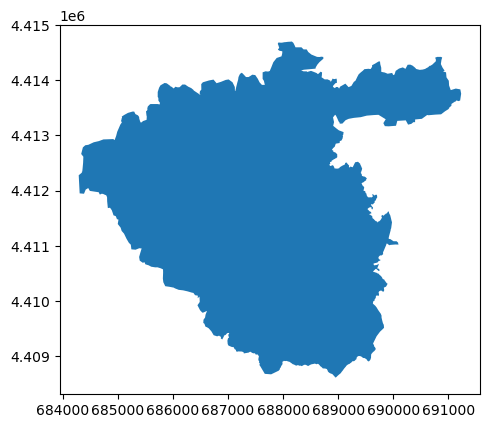

In [6]:
burn_scar.plot()
plt.show()

#### Function to clip raster with shapefile

In [7]:
"""
Function: Clip singleband raster with shapefile. Raster and shapefile must have
same CRS.

Inputs:
rst - singleband raster
shp - shapefile that has been read by geopandas
save - (True/False) whether to save raster
out_path - output file path if saving raster

Outputs - clipped raster
"""
def clip_rst_w_shp(rst, shp, save, out_path):
    out_rst = rst.rio.clip(shp.geometry.apply(mapping), 
                             all_touched=True, 
                             drop = True)

    if save:
        out_rst.rio.to_raster(out_path)
        print('raster saved')
        
    return out_rst

In [8]:
for folder in folders:
    # create folder path
    landsat = os.path.join(unclip_path, folder)
    # change working directory to that path
    os.chdir(landsat)
    
    # get only the bands we need from the Landsat folder
    # for Landsat 8 & 9 data, we need bands 4 & 5 for NDVI
    if folder.startswith('LC08') or folder.startswith('LC09'):
        rasters = glob.glob('*[45].TIF')
    # for Landsat 5 data, we need bands 3 & 4 for NDVI and 4 & 7 for NBR
    # only need to calculate NBR for 2008
    elif "2008" in folder:
        rasters = glob.glob('*[347].TIF')
    else:
        rasters = glob.glob('*[34].TIF')
        
    # sort rasters to ensure the bands are in order
    rasters.sort()
        
    # create filename and output path for stacked rasters
    # needs to be done before rasters are reprojected and clipped
    # use first raster
    raster = rasters[0]
    
    # create raster name L***_YYYY_MM_DD to use when stacking and exporting
    rst_name = raster[:5] + raster[15:19] + '_' + raster[19:21] + '_' + raster[21:23] + '.tif'
    
    # create output path
    out_path = os.path.join(proc_path, rst_name)
    
    # reproject and clip each raster, replace in list
    for i in range(len(rasters)):
        # open raster
        src = rxr.open_rasterio(rasters[i])
        
        # reproject using shapefile CRS
        proj = src.rio.reproject(burn_scar.crs)
        
        # clip using shapefile
        clip = clip_rst_w_shp(proj, burn_scar, False, None)
        
        # mask pixels outside of shapefile boundary
        valid_range = (0, clip.max())
        if valid_range:
            mask = ((clip == valid_range[0]) | (clip > valid_range[1]))
            rasters[i] = clip.where(~xr.where(mask, True, False))
            
    # stack raster bands
    stack = xr.concat(rasters, dim='band')

    # export stacked rasters
    stack.rio.to_raster(out_path)

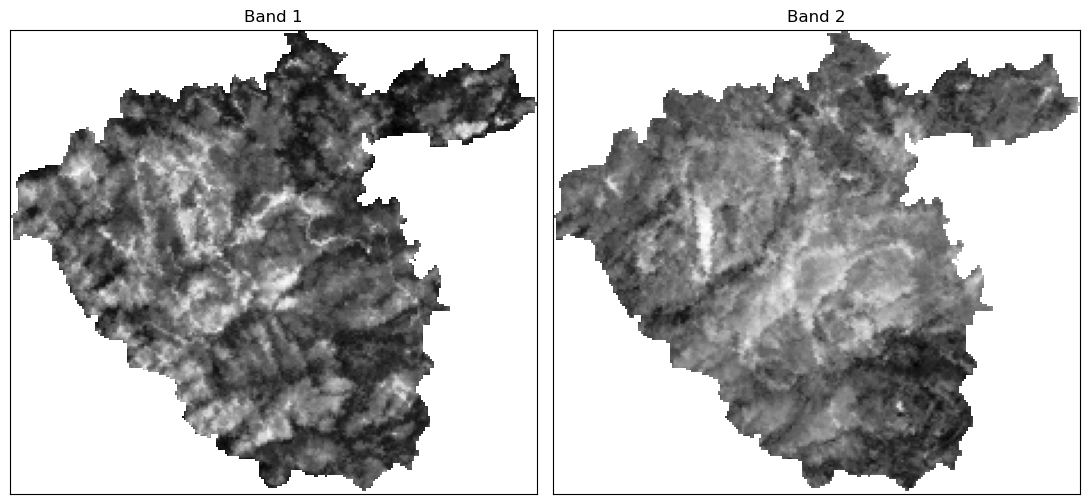

In [9]:
# plot last stack of rasters processed - note the bands have been renumbered
ep.plot_bands(stack,
              figsize=(11, 6),
              cols=2,
              cbar=False)
plt.show()

## Calculate NBR and dNBR for year of fire using rasterio using rioxarray

The Cold Fire started on June 21, 2008; pre-fire Landsat data is from June 5, 2008. It was declared contained on August 21, 2008; post-fire Landsat data is from September 2, 2008.<br><br>
NBR = (NIR - SWIR) / (NIR + SWIR)  
In Landsat 5, NBR = (Band 4 – Band 7) / (Band 4 + Band 7).  

#### Folder and file paths

In [10]:
# Landsat from before the fire
pre_fire_path = r"C:\Users\cowsp\OneDrive\ISU\Spring_23\GEOL6628\final_project\data\landsat\processed\LT05_2008_06_05.tif"

# Landsat stack from after the fire in 2008
post_fire_path = r"C:\Users\cowsp\OneDrive\ISU\Spring_23\GEOL6628\final_project\data\landsat\processed\LT05_2008_09_02.tif"

# create folder for calculated rasters
calc_path = os.path.join(ls_path, 'calculated')
os.mkdir(calc_path)

Bands were renumbered in previous section but were stacked in order.  
Red = Band 1  
NIR = Band 2  
MIR = Band 3

In [11]:
# load NIR and MIR bands pre-fire
pre_fire_data = rxr.open_rasterio(pre_fire_path)

# load NIR and MIR bands post-fire
post_fire_data = rxr.open_rasterio(post_fire_path)

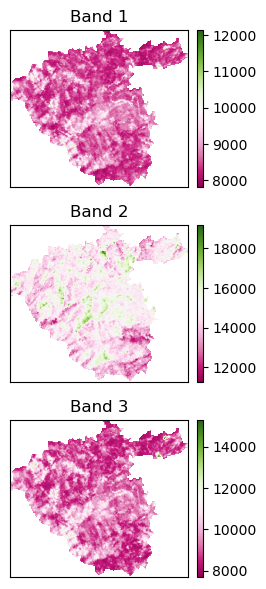

In [13]:
ep.plot_bands(pre_fire_data,
              figsize=(11, 6),
              cols=1,
              cmap='PiYG',
              cbar=True)
plt.show()

In [14]:
# calculate NBR pre-fire
pre_nbr = (pre_fire_data[1] - pre_fire_data[2]) / (pre_fire_data[1] + pre_fire_data[2])

# calculate NBR post-fire
post_nbr = (post_fire_data[1] - post_fire_data[2]) / (post_fire_data[1] + post_fire_data[2])

<Axes: title={'center': 'Differenced Normalized Burn Ratio\n Post-Cold Fire'}>

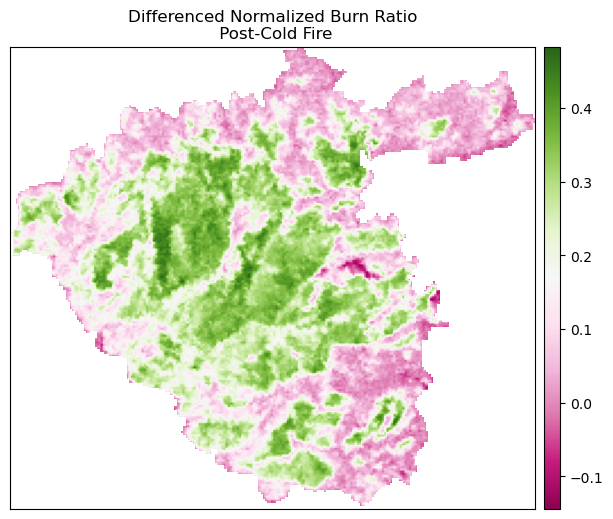

In [180]:
# calculate dNBR
dnbr = pre_nbr - post_nbr

# plot dNBR
fig, ax = plt.subplots(figsize=(12, 6))

ep.plot_bands(dnbr,
              cmap='PiYG',
              vmin=dnbr.min(),
              vmax=dnbr.max(),
              ax=ax,
              title="Differenced Normalized Burn Ratio\n Post-Cold Fire")

In [18]:
# raster paths for export
pre_nbr_path = os.path.join(calc_path, 'pre_nbr.tif')
post_nbr_path = os.path.join(calc_path, 'post_nbr.tif')
dnbr_path = os.path.join(calc_path, 'dnbr.tif')

In [19]:
# export rasters
pre_nbr.rio.to_raster(pre_nbr_path)
post_nbr.rio.to_raster(post_nbr_path)
dnbr.rio.to_raster(dnbr_path)

## Calculate NDVI, stack all NDVI rasters, and export using rioxarray and rasterio

NDVI = (NIR - R) / (NIR + R)  
In Landsat 5, NDVI = (Band 4 – Band 3) / (Band 4 + Band 3).  
In Landsat 8-9, NDVI = (Band 5 – Band 4) / (Band 5 + Band 4).

In [20]:
# get list of Landsat files in processed folder
os.chdir(proc_path)
proc_rasters = glob.glob('*[0-9].TIF')
print(proc_rasters)

['LC08_2013_06_28.tif', 'LC08_2014_06_22.tif', 'LC08_2015_06_25.tif', 'LC08_2016_06_20.tif', 'LC08_2017_06_23.tif', 'LC08_2018_06_26.tif', 'LC08_2019_06_29.tif', 'LC08_2020_07_01.tif', 'LC08_2021_06_18.tif', 'LC09_2022_06_29.tif', 'LT05_2008_06_05.tif', 'LT05_2008_09_02.tif', 'LT05_2009_06_24.tif', 'LT05_2010_07_06.tif', 'LT05_2011_07_16.tif']


In [21]:
# calculate NDVI for all the rasters and export
for raster in proc_rasters:
    # create output path for NDVI raster
    out_path = os.path.join(calc_path, 'NDVI_' + raster[5:-4] + '.tif')
    
    # open raster
    src = rxr.open_rasterio(raster)
    
    # calculate NDVI
    ndvi = (src[1] - src[0]) / (src[1] + src[0])
    
    # export raster
    ndvi.rio.to_raster(out_path)

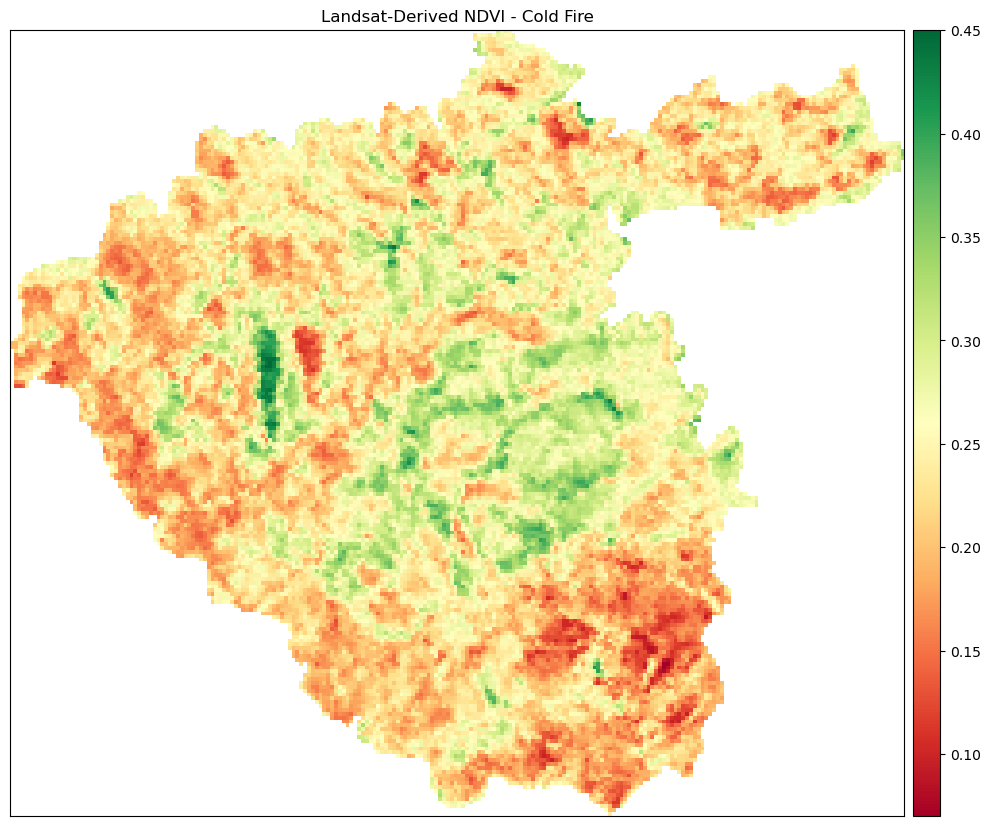

<Axes: title={'center': 'Landsat-Derived NDVI - Cold Fire'}>

In [22]:
# plot last NDVI calculated
ep.plot_bands(ndvi,
              cmap='RdYlGn',
              scale=False,
              vmin=ndvi.min(), vmax=ndvi.max(),
              title="Landsat-Derived NDVI - Cold Fire")

In [23]:
# get list of NDVI rasters in calcuated folder
os.chdir(calc_path)
calc_rasters = glob.glob('*[0-9].TIF')

# sort rasters
calc_rasters.sort()

print(calc_rasters)

['NDVI_2008_06_05.tif', 'NDVI_2008_09_02.tif', 'NDVI_2009_06_24.tif', 'NDVI_2010_07_06.tif', 'NDVI_2011_07_16.tif', 'NDVI_2013_06_28.tif', 'NDVI_2014_06_22.tif', 'NDVI_2015_06_25.tif', 'NDVI_2016_06_20.tif', 'NDVI_2017_06_23.tif', 'NDVI_2018_06_26.tif', 'NDVI_2019_06_29.tif', 'NDVI_2020_07_01.tif', 'NDVI_2021_06_18.tif', 'NDVI_2022_06_29.tif']


In [24]:
# stack and save rasters
# read metadata of first file
with rasterio.open(calc_rasters[0]) as src0:
    meta = src0.meta

# update meta to reflect the number of rasters
meta.update(count = len(calc_rasters))

# read each raster and write it to stack
with rasterio.open('ndvi_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(calc_rasters, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

In [25]:
ndvi_stack_path = os.path.join(calc_path, 'ndvi_stack.tif')

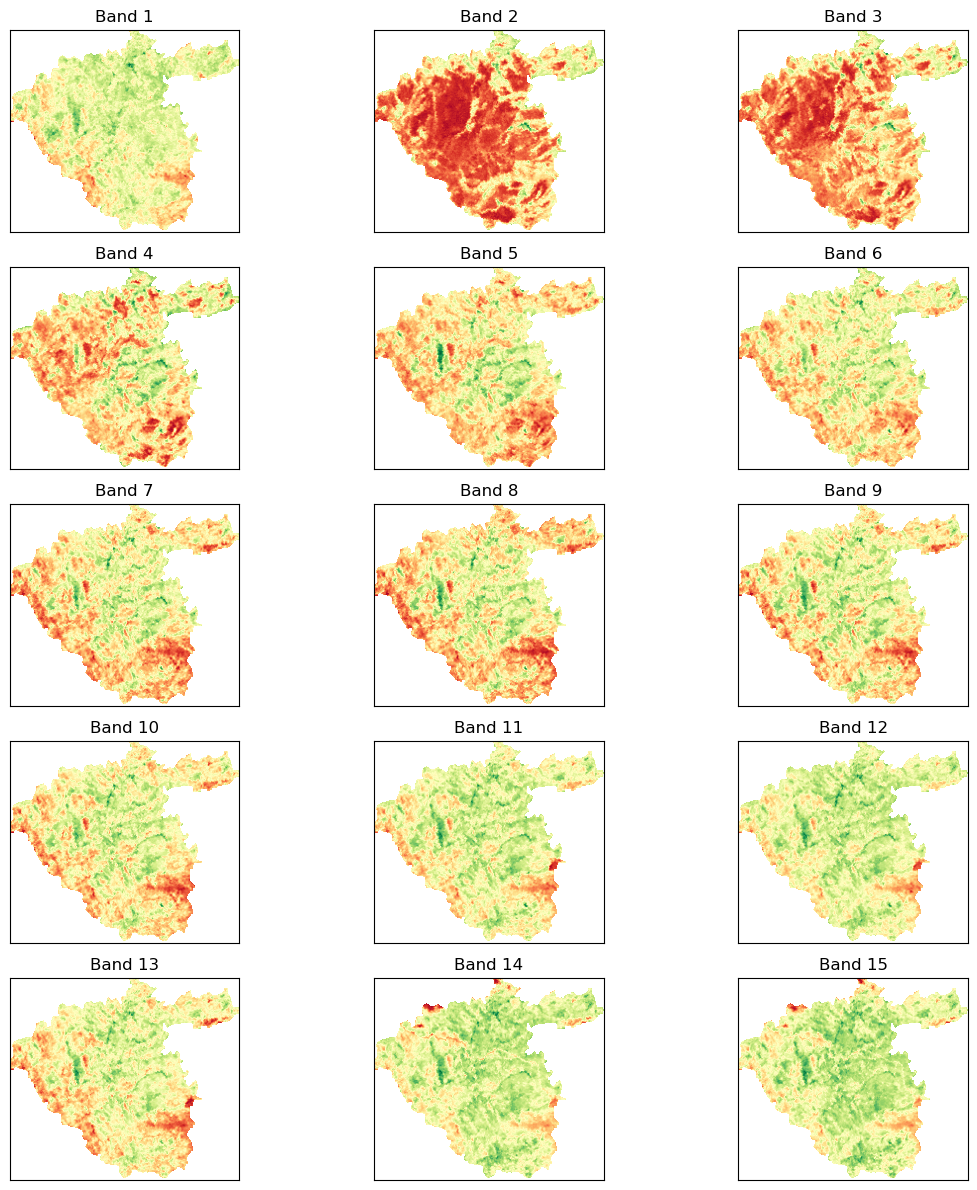

In [26]:
# open stack of NDVI rasters
ndvi_stack = rxr.open_rasterio(ndvi_stack_path)

# plot stack of rasters
ep.plot_bands(ndvi_stack,
              cmap='RdYlGn',
              cols=3,
              cbar=False)
plt.show()

<div class="alert alert-block alert-info">
    <b>Animate it!</b><br>
    A fun side project is to animate the NDVI rasters to see how NDVI changes
    over time. This can be done in R using the <em>av</em> and <em>raster</em>
    packages.
    
```
stack <- stack("C:/Users/cowsp/OneDrive/ISU/Spring_23/GEOL6628/final_project/data/landsat/calculated/ndvi_stack.tif")
                 
names(stack) <- c(
  'NDVI 2008 Pre-fire',
  'NDVI 2008 Post-fire',
  'NDVI 2009',
  'NDVI 2010',
  'NDVI 2011',
  'NDVI 2013',
  'NDVI 2014',
  'NDVI 2015',
  'NDVI 2016',
  'NDVI 2017',
  'NDVI 2018',
  'NDVI 2019',
  'NDVI 2020',
  'NDVI 2021',
  'NDVI 2022'
)
                 
out_path <- "C:/Users/cowsp/OneDrive/ISU/Spring_23/GEOL6628/final_project/R/ndvi_animated.mp4"

av_capture_graphics( raster::animate(stack, n=1), 
                     output = out_path, 
                     width = 720, 
                     height = 480, 
                     framerate = 0.75, 
                     vfilter = "null", 
                     audio = NULL, 
                     verbose = TRUE )
```
</div>

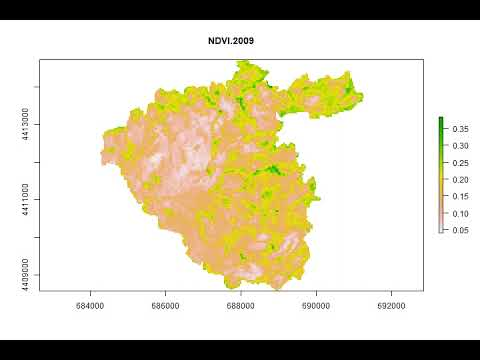

In [27]:
from IPython import display
display.YouTubeVideo('3ia7ZIpCiuQ', width=500)

__[Link to video](https://youtu.be/3ia7ZIpCiuQ)__

## Reproject, co-register, and clip SRTM DEM using rixoarray and rasterio. 

### Acknowledgements
The code for co-registering rasters came from __[PyGIS](https://pygis.io/docs/e_raster_resample.html)__
by Michael Mann, Steven Chao, Jordan Graesser, Nina Feldman.<br><br>
The code for interpolating missing pixel values in the aspect raster was adapted from a conversation with ChatGPT, a language model trained by OpenAI, on April 7, 2023.

### Reproject and co-register SRTM

<div class="alert alert-block alert-warning">
Before co-registering, we need a Landsat raster clipped to the fire perimeter with a 300 meter buffer.
</div>

In [28]:
# pick a Landsat raster
ls_rst_path = r"C:\Users\cowsp\OneDrive\ISU\Spring_23\GEOL6628\final_project\data\landsat\unclipped\LC08_CU_003007_20130628_20210501_02_SR\LC08_CU_003007_20130628_20210501_02_SR_B1.TIF"

In [29]:
buff_clip_path = r"C:\Users\cowsp\OneDrive\ISU\Spring_23\GEOL6628\final_project\data\cold_fire_perimeter_300m_buff\cold_fire_perimeter_300m_buff.shp"
# read shapefile with geopandas
buff_clip = gpd.read_file(buff_clip_path)

In [30]:
ls_300m_path = os.path.join(ls_path, 'ls_300m_clip.tif')

with rxr.open_rasterio(ls_rst_path) as src:
    # reproject using shapefile CRS
    proj_ls = src.rio.reproject(buff_clip.crs)
    
    # clip Landsat raster and save
    clip_rst_w_shp(proj_ls, buff_clip, True, ls_300m_path)

raster saved


Time to co-register!

In [31]:
# SRTM DEM path
srtm_path = os.path.join(path, 'SRTM')
dem_path = os.path.join(srtm_path, 'SRTM_n39_w121_1arc_v2.tif')

In [32]:
# load DEM
dem = rxr.open_rasterio(dem_path)

In [33]:
# reproject DEM using bilinear interpolation
dem_proj = dem.rio.reproject(buff_clip.crs, resampling=eResampling.bilinear)

In [34]:
# create path for reprojected DEM
dem_proj_path = os.path.join(srtm_path, 'dem_proj.tif')

In [35]:
# export reprojected DEM
dem_proj.rio.to_raster(dem_proj_path)

#### Function to co-register raster

In [36]:
def reproj_match(infile, match, outfile):
    """Reproject a file to match the shape and projection of existing raster. 
    
    Parameters
    ----------
    infile : (string) path to input file to reproject
    match :  (string) path to raster with desired shape and projection 
    outfile : (string) path to output file tif
    """
    # open input
    with rasterio.open(infile) as src:
        src_transform = src.transform
        
        # open input to match
        with rasterio.open(match) as match:
            dst_crs = match.crs

            # calculate the output transform matrix
            dst_transform, dst_width, dst_height = calculate_default_transform(
                src.crs,     # input CRS
                dst_crs,     # output CRS
                match.width,   # input width
                match.height,  # input height 
                *match.bounds,  # unpacks input outer boundaries (left, bottom, right, top)
            )

        # set properties for output
        dst_kwargs = src.meta.copy()
        dst_kwargs.update({"crs": dst_crs,
                           "transform": dst_transform,
                           "width": dst_width,
                           "height": dst_height,
                           "nodata": 0})
        print("Coregistered to shape:", dst_height,dst_width,'\n Affine',dst_transform)
        
        # open output
        with rasterio.open(outfile, "w", **dst_kwargs) as dst:
            # iterate through bands and write using reproject function
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=dst_transform,
                    dst_crs=dst_crs,
                    resampling=eResampling.bilinear)

In [37]:
# file path for co-registered DEM
dem_co_reg_path = os.path.join(srtm_path, 'dem_co_reg.tif')

In [38]:
# co-register SRTM DEM to match Landsat
reproj_match(infile = dem_proj_path, 
             match= ls_300m_path,
             outfile = dem_co_reg_path)

Coregistered to shape: 224 252 
 Affine | 30.14, 0.00, 683960.06|
| 0.00,-30.14, 4415029.56|
| 0.00, 0.00, 1.00|


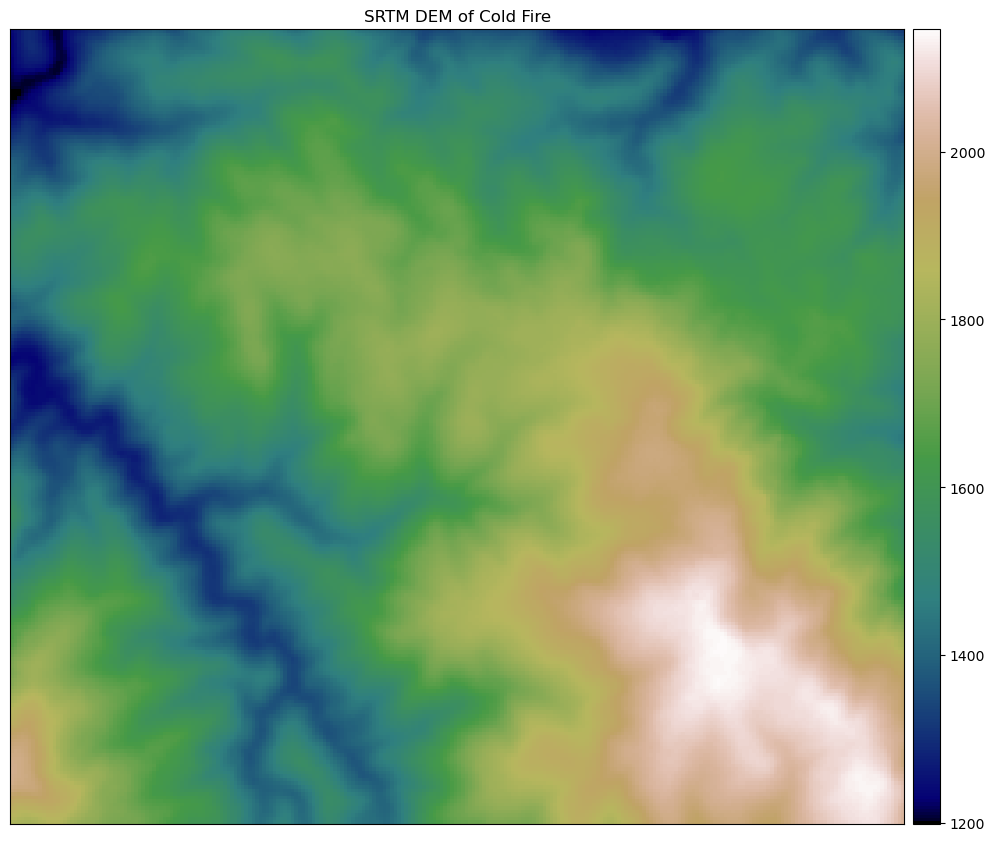

<Axes: title={'center': 'SRTM DEM of Cold Fire'}>

In [39]:
# open and plot co-registered raster
dem_co_reg = rxr.open_rasterio(dem_co_reg_path)

ep.plot_bands(dem_co_reg,
              cmap='gist_earth',
              title="SRTM DEM of Cold Fire")

## Calculate aspect and slope, clip, and export rasters using GDAL.
<a id='section3a'></a>
[TOC](#toc)

### Aspect

<div class="alert alert-block alert-info">
gdal.DEMProcessing() wasn't working for me, so I used the command line in Python instead. Here's the code for using DEMProcessing:
    
```
aspect = gdal.DEMProcessing(aspect_path, 
                            dem_clip_path,
                            processing='aspect',
                            format='GTiff',
                            band=1)

slope = gdal.DEMProcessing(slope_path, 
                            dem_clip_path, 
                            processing='slope', 
                            format='GTiff',
                            band=1,
                            scale=1.0)
```
</div>

In [40]:
# aspect output path
aspect_path = os.path.join(srtm_path, 'aspect.tif')

In [41]:
# calculate aspect and export raster
command = f'gdaldem aspect {dem_co_reg_path} {aspect_path} -of GTiff -b 1'
os.system(command)

0

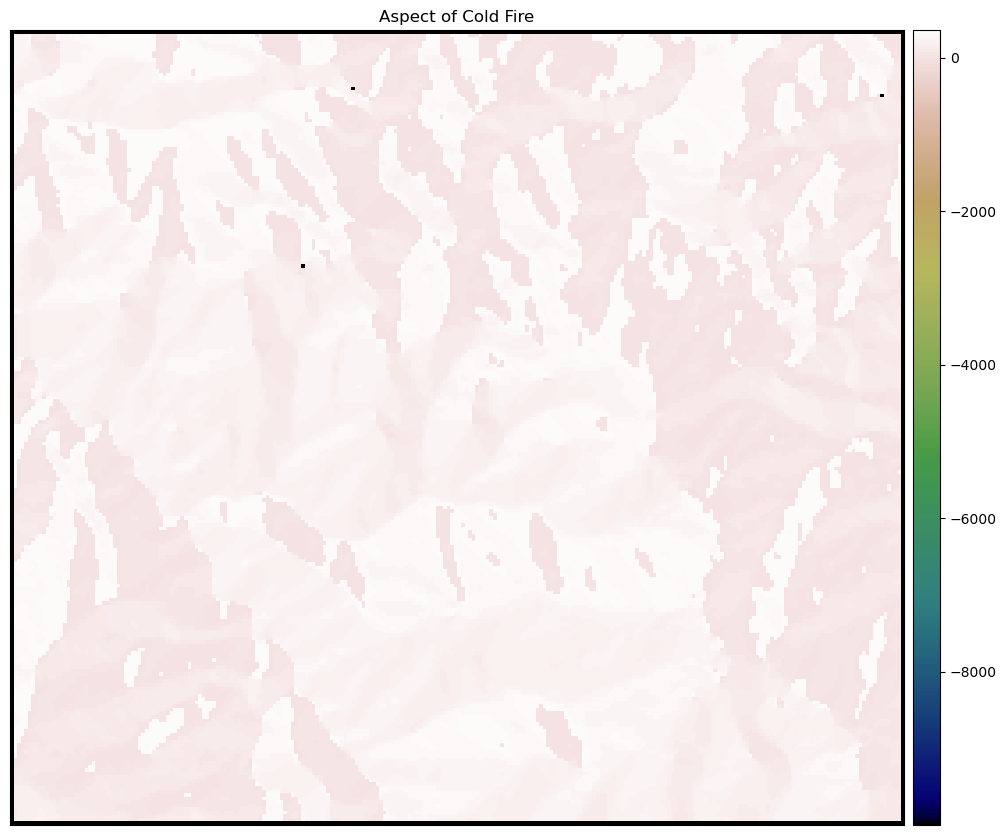

<Axes: title={'center': 'Aspect of Cold Fire'}>

In [42]:
# open aspect raster
aspect_in = rxr.open_rasterio(aspect_path).squeeze()

# plot raster to verify
ep.plot_bands(aspect_in,
              cmap='gist_earth',
              title="Aspect of Cold Fire")

<div class="alert alert-block alert-warning">
My aspect raster had pixels with NoData. That needs to be fixed.
</div>

In [43]:
aspect_fill_path = os.path.join(srtm_path, 'aspect_fill.tif')

In [44]:
# Open input raster and read as numpy array
with rasterio.open(aspect_path) as src:
    arr = src.read(1)
    profile = src.profile

# Create a mask of valid pixels
mask = arr != profile['nodata']

# Generate a grid of pixel coordinates
x, y = np.meshgrid(np.arange(arr.shape[1]), np.arange(arr.shape[0]))

# Flatten the pixel coordinates and values
x = x[mask].flatten()
y = y[mask].flatten()
vals = arr[mask].flatten()

# Create a grid of coordinates for the output raster
out_shape = (profile['height'], profile['width'])
out_x, out_y = np.meshgrid(np.arange(out_shape[1]), np.arange(out_shape[0]))

# Interpolate the missing pixel values
out_arr = griddata((x, y), vals, (out_x, out_y), method='linear', fill_value=np.nan)

# Write the output raster
profile.update(dtype=rasterio.float32, nodata=np.nan)
with rasterio.open(aspect_fill_path, 'w', **profile) as dst:
    dst.write(out_arr.astype(rasterio.float32), 1)

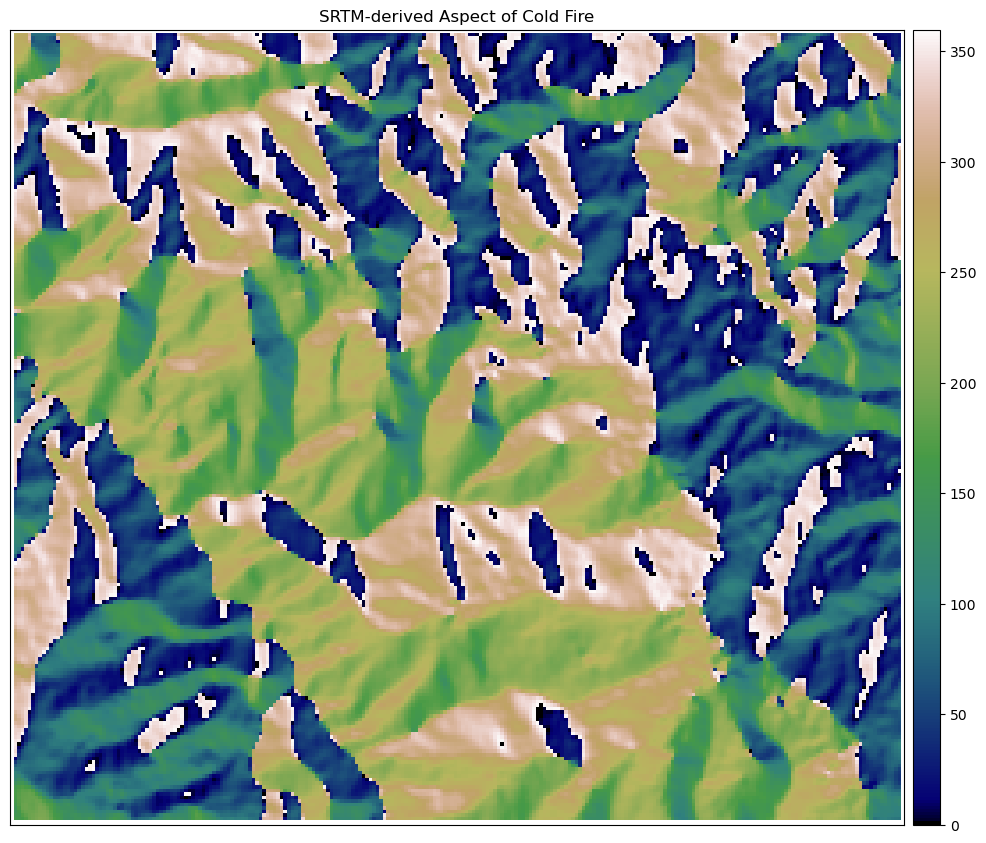

<Axes: title={'center': 'SRTM-derived Aspect of Cold Fire'}>

In [45]:
# open aspect raster
aspect_fill_in = rxr.open_rasterio(aspect_fill_path)

# plot raster to verify
ep.plot_bands(aspect_fill_in,
              cmap='gist_earth',
              title="SRTM-derived Aspect of Cold Fire")

Much better!

#### Transform aspect to northernly and easterly
For the random forest regression, aspect needs to be continuous. We will transform aspect to northernly, cosine of aspect, and easterly, sine of aspect. A value of 1 is most northernly/easternly, and a value of -1 is most southernly/westernly.

In [46]:
# create file paths for transformed rasters
n_aspect_path = os.path.join(srtm_path, 'n_aspect.tif')
e_aspect_path = os.path.join(srtm_path, 'e_aspect.tif')

In [47]:
# calculate northernly/easternly and save raster
with rasterio.open(aspect_fill_path) as src:
    # read aspect raster
    aspect = src.read(1)
    # calculate northernly
    n_aspect = np.cos((np.pi / 180)*aspect)
    # calculate easternly
    e_aspect = np.sin((np.pi / 180)*aspect)
    # save rasters
    with rasterio.open(n_aspect_path, "w", **src.profile) as dst:
        dst.write(n_aspect, 1)
    with rasterio.open(e_aspect_path, "w", **src.profile) as dst:
        dst.write(e_aspect, 1)

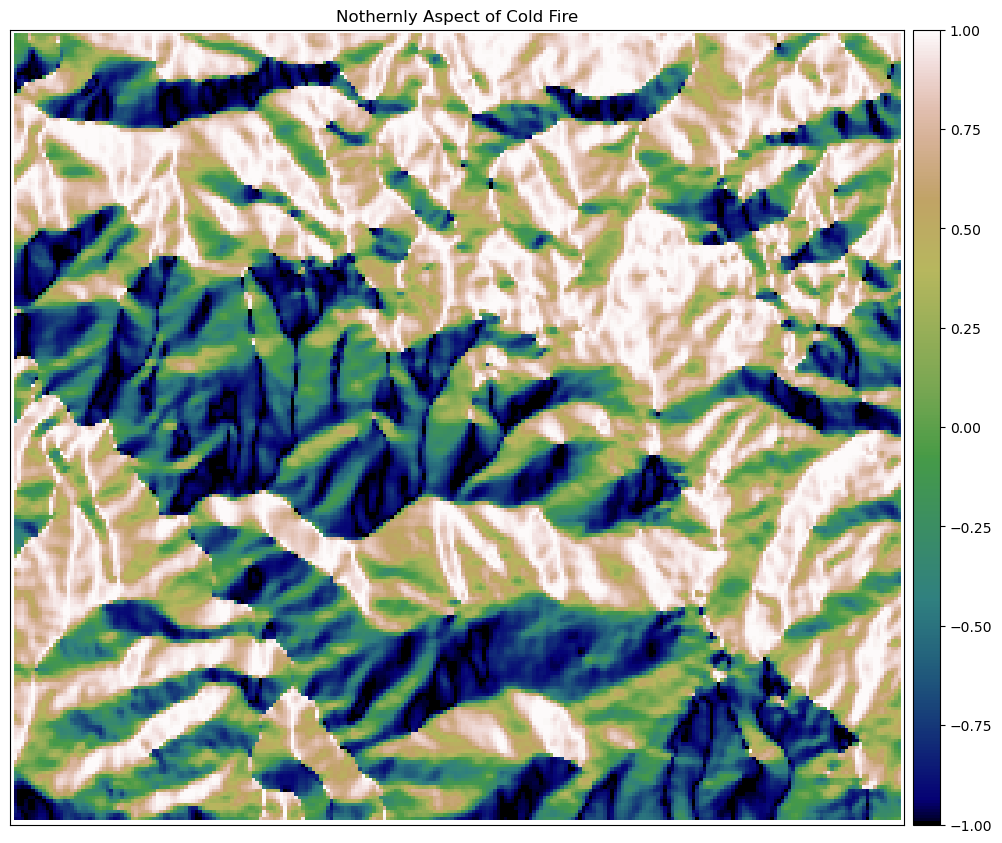

<Axes: title={'center': 'Nothernly Aspect of Cold Fire'}>

In [48]:
# open northernly raster
n_aspect_in = rxr.open_rasterio(n_aspect_path)

# plot raster to verify
ep.plot_bands(n_aspect_in,
              cmap='gist_earth',
              title="Nothernly Aspect of Cold Fire")

### Slope

In [49]:
# slope output path
slope_path = os.path.join(srtm_path, 'slope.tif')

In [50]:
# calculate slope and export raster
command = f'gdaldem slope {dem_co_reg_path} {slope_path} -of GTiff -b 1 -s 1.0'
os.system(command)

0

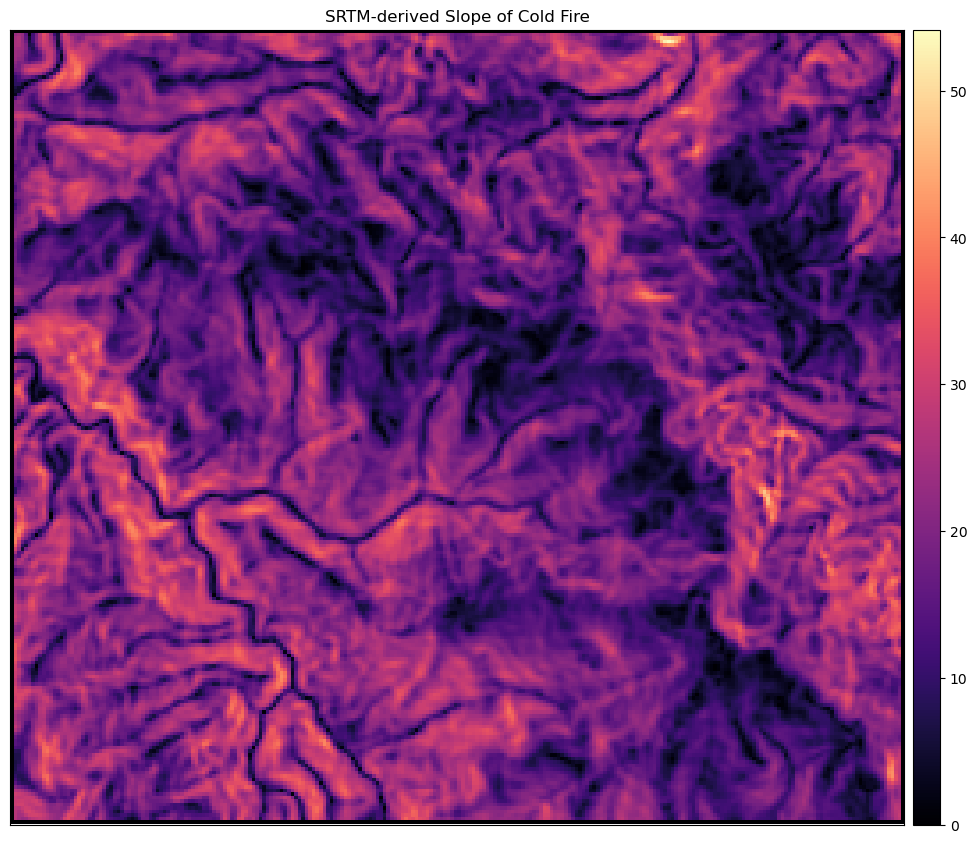

<Axes: title={'center': 'SRTM-derived Slope of Cold Fire'}>

In [134]:
# plot slope using rioxarray and earthpy
slope_in = rxr.open_rasterio(slope_rio_path)
         
ep.plot_bands(slope_in,
              cmap='magma',
              vmin=0,
              title="SRTM-derived Slope of Cold Fire")

### Clip SRTM-derived rasters

#### Function to clip raster with raster
This ensures the SRTM-derived rasters will have the exact same extent as the NDVI rasters.

#### Clip rasters

In [138]:
# file paths for clipped rasters
aspect_clip_path = os.path.join(srtm_path, 'aspect_clip.tif')
north_clip_path = os.path.join(srtm_path, 'north_clip.tif')
east_clip_path = os.path.join(srtm_path, 'east_clip.tif')
slope_clip_path = os.path.join(srtm_path, 'slope_clip.tif')

In [136]:
clip_rst_w_shp(aspect_fill_in, burn_scar, True, aspect_clip_path)
clip_rst_w_shp(n_aspect_in, burn_scar, True, north_clip_path)
with rxr.open_rasterio(e_aspect_path) as rst:
    clip_rst_w_shp(rst, burn_scar, True, east_clip_path)
clip_rst_w_shp(slope_in, burn_scar, True, slope_clip_path)

raster saved


<xarray.DataArray (band: 1, y: 204, x: 232)>
array([[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]]],
      dtype=float32)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 6.843e+05 6.843e+05 ... 6.912e+05 6.912e+05
  * y            (y) float64 4.415e+06 4.415e+06 ... 4.409e+06 4.409e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -9999.0

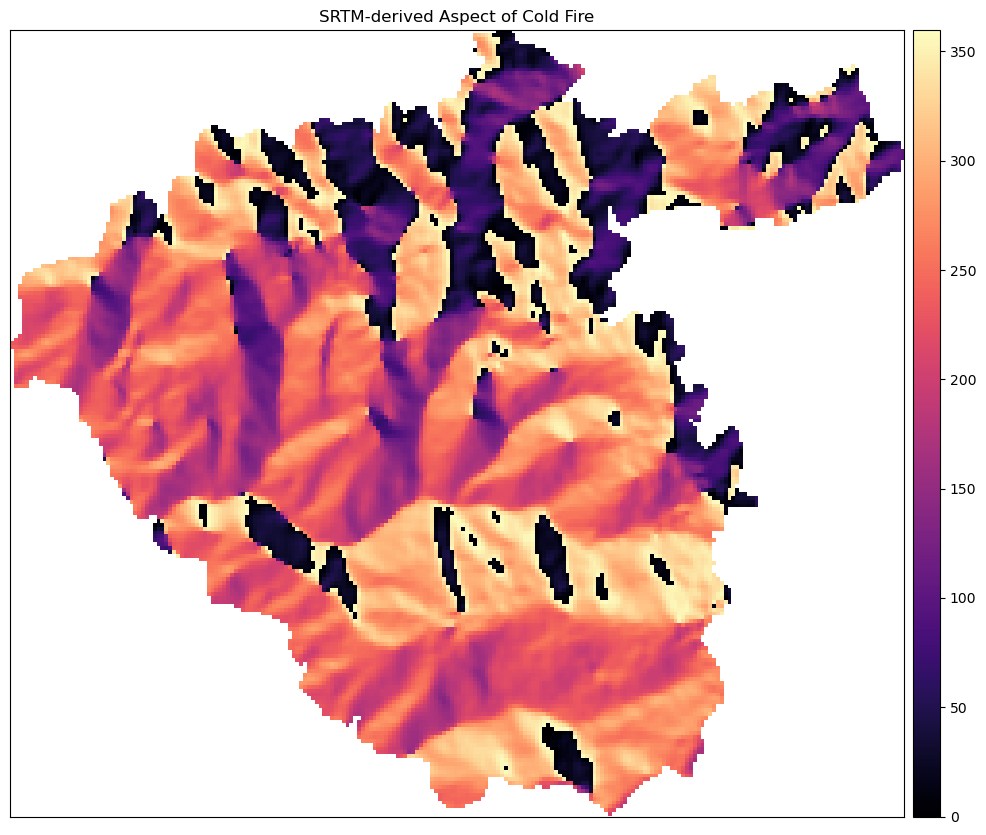

<Axes: title={'center': 'SRTM-derived Aspect of Cold Fire'}>

In [140]:
# plot aspect using rioxarray and earthpy
aspect_clip_in = rxr.open_rasterio(aspect_clip_path)
         
ep.plot_bands(aspect_clip_in,
              cmap='magma',
              vmin=0,
              title="SRTM-derived Aspect of Cold Fire")

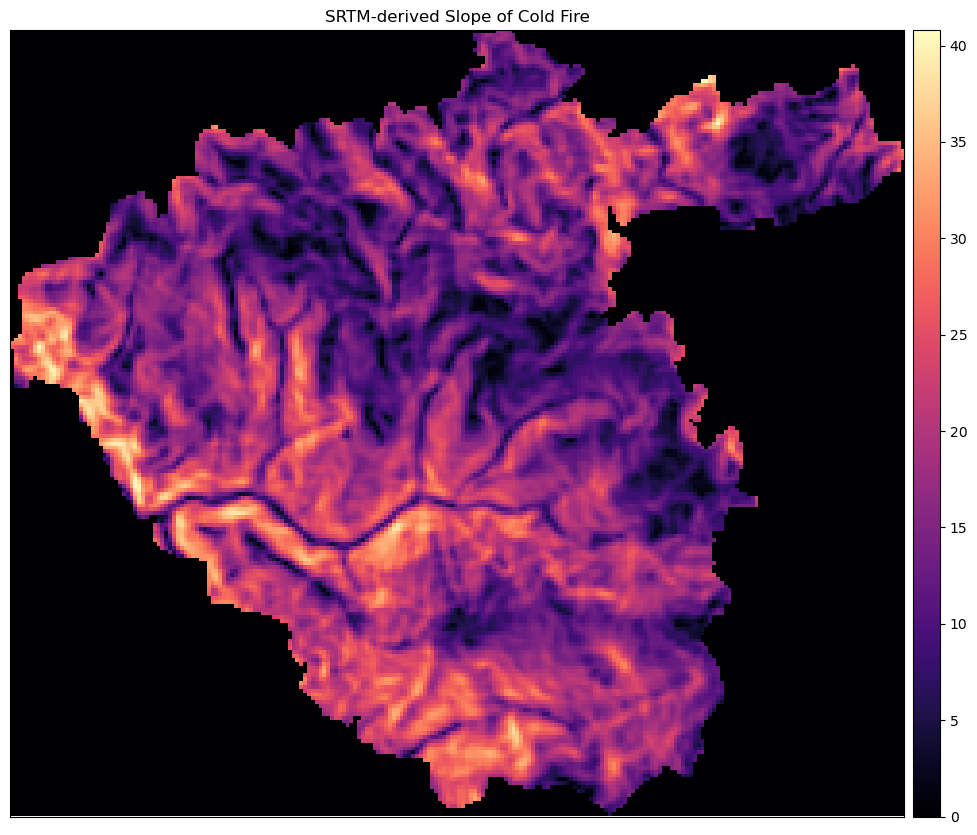

<Axes: title={'center': 'SRTM-derived Slope of Cold Fire'}>

In [137]:
# plot slope using rioxarray and earthpy
slope_clip_in = rxr.open_rasterio(slope_clip_path)
         
ep.plot_bands(slope_clip_in,
              cmap='magma',
              vmin=0,
              title="SRTM-derived Slope of Cold Fire")

<div class="alert alert-block alert-warning">
For some reason, when I clip aspect, the 'no data' are 'nan,' but when I clip slope, they are -9999. That needs to be fixed so that the slope data is the same size as the aspect data for the random forest regression.
</div>

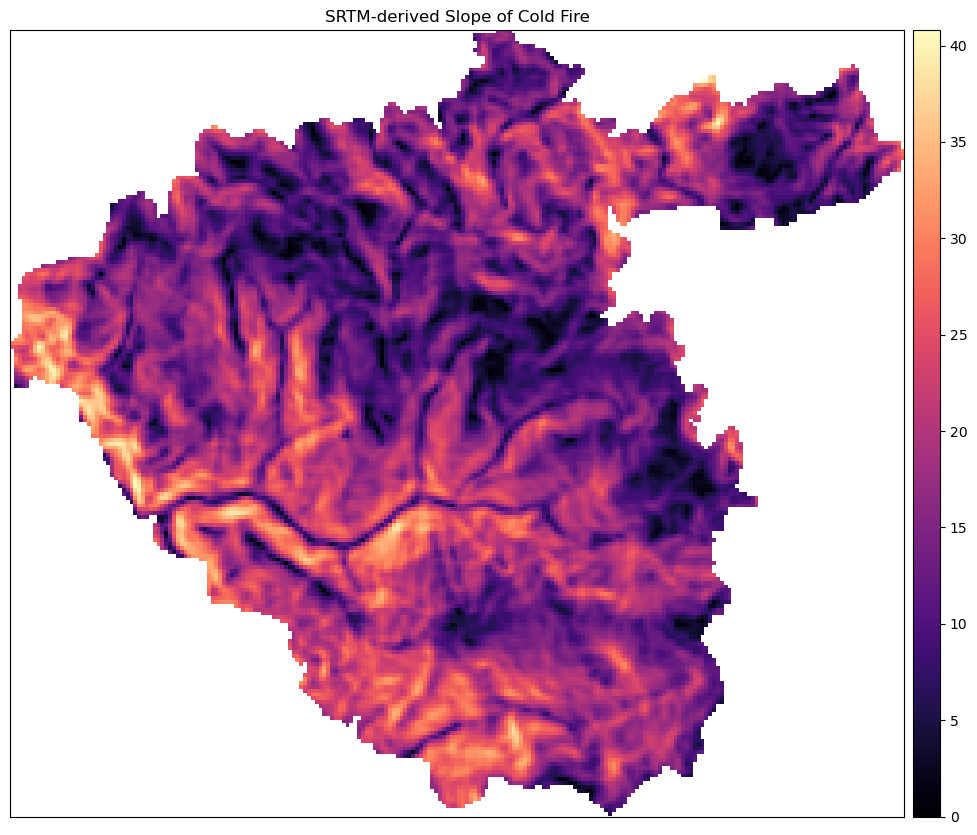

<Axes: title={'center': 'SRTM-derived Slope of Cold Fire'}>

In [144]:
# mask pixels outside of shapefile boundary
valid_range = (0, slope_clip_in.max())

if valid_range:
    mask = (slope_clip_in < valid_range[0] | (slope_clip_in > valid_range[1]))
    slope_mask = slope_clip_in.where(~xr.where(mask, True, False))
    
ep.plot_bands(slope_mask,
              cmap='magma',
              vmin=0,
              title="SRTM-derived Slope of Cold Fire")

Much better!

In [145]:
# create slope mask path
slope_mask_path = os.path.join(srtm_path, 'slope_mask.tif')
# export  slope raster
slope_mask.rio.to_raster(slope_mask_path)

## Clip and export aspect, slope, and dNBR rasters to make a raster for each class using rioxarray

To compare the relationship between vegetation regrowth and topography, as well as vegetation regrowth and burn severity using a linear regression, a raster for each class for slope, aspect, and dNBR needs to be created.

In [55]:
# create folder path for classified rasters
class_path = os.path.join(path, 'classifications')

In [56]:
# create folder for classified rasters
os.mkdir(class_path)

North-facing: NE, N  
South-facing: S, SW

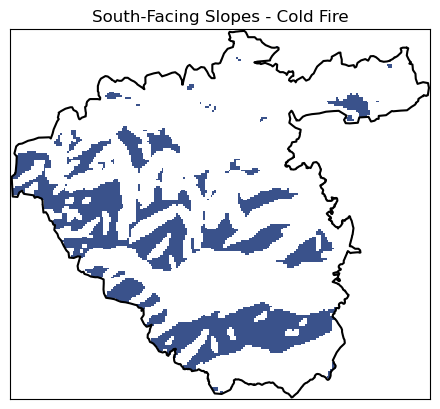

In [169]:
# open aspect raster
aspect_in = rxr.open_rasterio(aspect_clip_path)

# south-facing slopes
valid_range = (157.5, 247.5)
if valid_range:
    mask = ((aspect_in < valid_range[0]) | (aspect_in > valid_range[1]))
    south_aspect = aspect_in.where(~xr.where(mask, True, False))
    
viridisBig = colormaps['viridis']
newcmp = ListedColormap(viridisBig(np.linspace(0.25, 0.25, 256)))

# plot to verify
f, ax = plt.subplots()

ep.plot_bands(south_aspect,
              ax=ax,
              cmap=newcmp,
              cbar=False,
              extent=plotting_extent(south_aspect[0], 
                                         south_aspect.rio.transform()),
              title="South-Facing Slopes - Cold Fire")

burn_scar.boundary.plot(ax=ax, color='black')
plt.show()

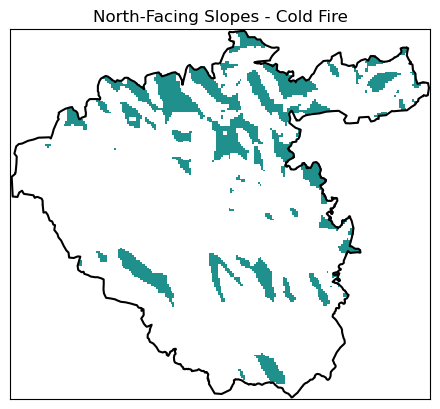

In [167]:
# north-facing slopes
valid_range = (0, 67.5, 337.5, 360)
if valid_range:
    mask = ((aspect_in < valid_range[0]) | 
            ((aspect_in > valid_range[1]) & (aspect_in < valid_range[2])) |
            (aspect_in > valid_range[3]))
    north_aspect = aspect_in.where(~xr.where(mask, True, False))
    
viridisBig = colormaps['viridis']
newcmp = ListedColormap(viridisBig(np.linspace(0.5, 0.5, 256)))
            
# plot to verify
f, ax = plt.subplots()

ep.plot_bands(north_aspect,
              ax=ax,
              cmap=newcmp,
              cbar=False,
              extent=plotting_extent(north_aspect[0], 
                                         north_aspect.rio.transform()),
              title="North-Facing Slopes - Cold Fire")

burn_scar.boundary.plot(ax=ax, color='black')
plt.show()

In [59]:
# create south aspect path
south_path = os.path.join(class_path, 'south_aspect.tif')
# create north aspect path
north_path = os.path.join(class_path, 'north_aspect.tif')

In [60]:
# export classified aspect raster
south_aspect.rio.to_raster(south_path)
# export classified aspect raster
north_aspect.rio.to_raster(north_path)

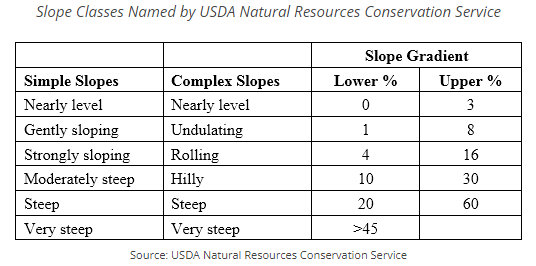<br>
Mild: 0 - 8%  
Moderate: 8 - 20%  
Steep: > 20%

In [174]:
# open slope raster
slope_in = rxr.open_rasterio(slope_clip_path)

In [119]:
slope_in.close()

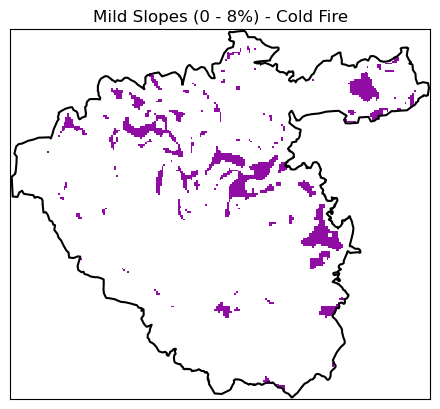

In [176]:
# mild slopes
valid_range = (0, 8)
if valid_range:
    mask = ((slope_in < valid_range[0]) | (slope_in > valid_range[1]))
    mild_slope = slope_in.where(~xr.where(mask, True, False))
    
plasmaBig = colormaps['plasma']
newcmp = ListedColormap(plasmaBig(np.linspace(0.3, 0.3, 256)))

# plot to verify
f, ax = plt.subplots()

ep.plot_bands(mild_slope,
              ax=ax,
              cmap=newcmp,
              cbar=False,
              extent=plotting_extent(mild_slope[0], 
                                         mild_slope.rio.transform()),
              title="Mild Slopes (0 - 8%) - Cold Fire")

burn_scar.boundary.plot(ax=ax, color='black')
plt.show()

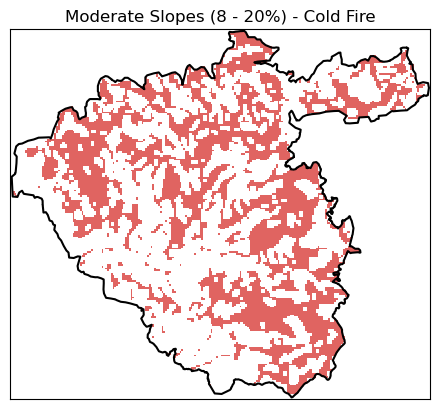

In [177]:
# moderate slopes
valid_range = (8, 20)
if valid_range:
    mask = ((slope_in <= valid_range[0]) | (slope_in > valid_range[1]))
    mod_slope = slope_in.where(~xr.where(mask, True, False))
    
plasmaBig = colormaps['plasma']
newcmp = ListedColormap(plasmaBig(np.linspace(0.6, 0.6, 256)))

# plot to verify
f, ax = plt.subplots()

ep.plot_bands(mod_slope,
              ax=ax,
              cmap=newcmp,
              cbar=False,
              extent=plotting_extent(mod_slope[0], 
                                         mod_slope.rio.transform()),
              title="Moderate Slopes (8 - 20%) - Cold Fire")

burn_scar.boundary.plot(ax=ax, color='black')
plt.show()

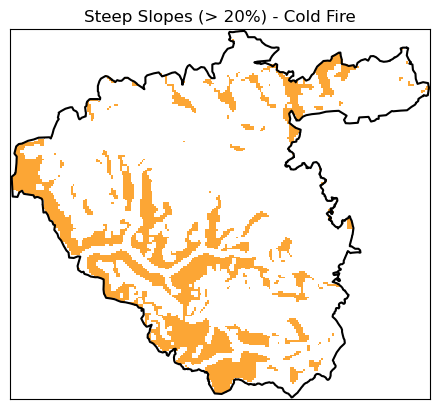

In [178]:
# steep slopes
valid_range = (0, 20)
if valid_range:
    mask = ((slope_in <= valid_range[1]))
    steep_slope = slope_in.where(~xr.where(mask, True, False))
    
plasmaBig = colormaps['plasma']
newcmp = ListedColormap(plasmaBig(np.linspace(0.8, 0.8, 256)))

# plot to verify
f, ax = plt.subplots()

ep.plot_bands(steep_slope,
              ax=ax,
              cmap=newcmp,
              cbar=False,
              extent=plotting_extent(steep_slope[0], 
                                         steep_slope.rio.transform()),
              title="Steep Slopes (> 20%) - Cold Fire")

burn_scar.boundary.plot(ax=ax, color='black')
plt.show()

In [65]:
# create mild slope path
mild_path = os.path.join(class_path, 'mild_slope.tif')
# create moderate slope path
mod_path = os.path.join(class_path, 'mod_slope.tif')
# create steep slope path
steep_path = os.path.join(class_path, 'steep_slope.tif')

In [66]:
# export classified slope raster
mild_slope.rio.to_raster(mild_path)
# export classified slope raster
mod_slope.rio.to_raster(mod_path)
# export classified slope raster
steep_slope.rio.to_raster(steep_path)

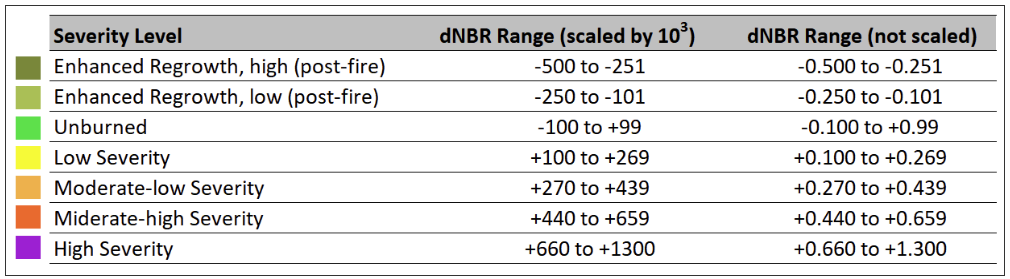<br>
First, let's plot a classified dNBR to get a feel for the burn severity levels.

In [67]:
# create class bins
class_bins = [-np.inf, -0.1, 0.1, 0.27, 0.44, np.inf]

# reclassify raster using bins
dnbr_class = xr.apply_ufunc(np.digitize, dnbr, class_bins)

# mask pixels outside of fire boundary
dnbr_class_mask = dnbr_class.where(dnbr_class != 6)

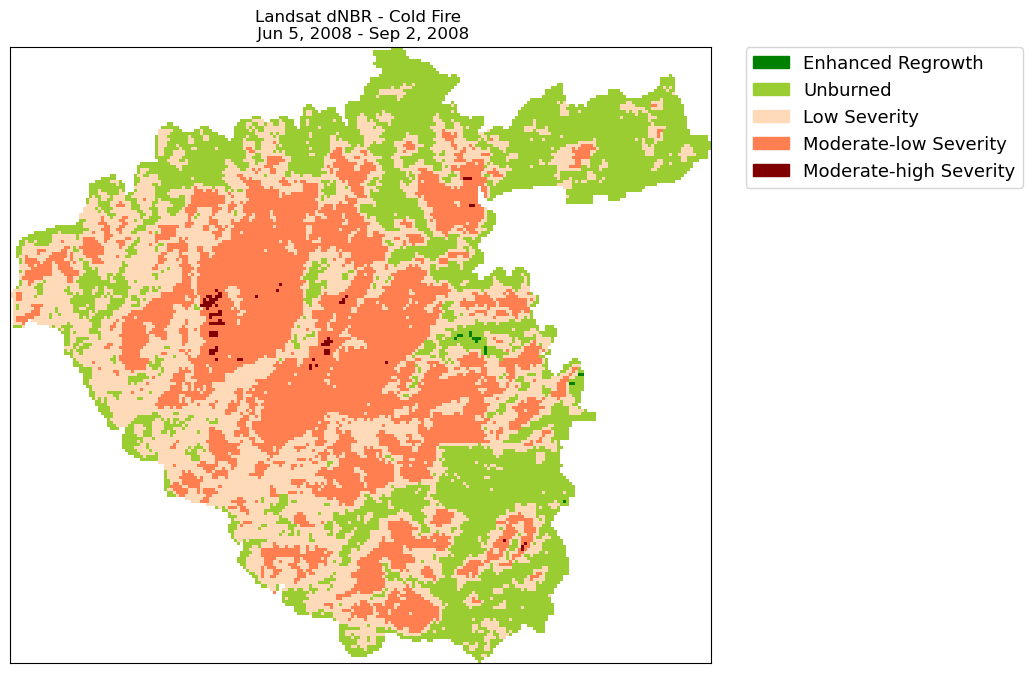

In [68]:
# plot dNBR classification

# legend
# category names
dnbr_cat_names = ["Enhanced Regrowth",
                  "Unburned",
                  "Low Severity",
                  "Moderate-low Severity",
                  "Moderate-high Severity"]

# category colors
dnbr_colors = ["g",
              "yellowgreen",
              "peachpuff",
              "coral",
              "maroon"]
nbr_cmap = ListedColormap(dnbr_colors)

# plot dNBR
fig, ax = plt.subplots(figsize=(10, 8))

classes = np.unique(dnbr_class_mask)
classes = classes.tolist()[:5]

ep.plot_bands(dnbr_class_mask,
              cmap=nbr_cmap,
              vmin=1,
              vmax=5,
              title="Landsat dNBR - Cold Fire \n Jun 5, 2008 - Sep 2, 2008",
              cbar=False,
              scale=False,
              ax=ax)

ep.draw_legend(im_ax=ax.get_images()[0],
               classes=classes,
               titles=dnbr_cat_names)

plt.show()

Since Enhanced Regrowth and Moderate-high Severity have so few pixels, we'll do three burn severity classes.

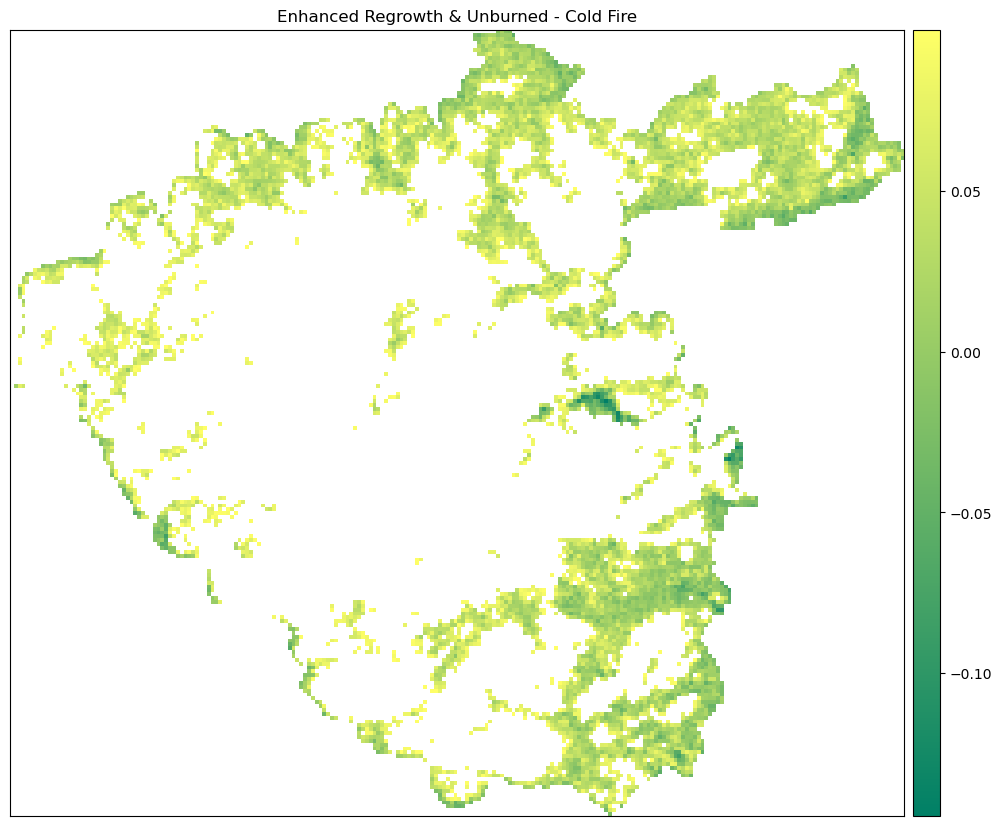

<Axes: title={'center': 'Enhanced Regrowth & Unburned - Cold Fire'}>

In [184]:
# enhanced regrowth and unburned < 0.1
valid_range = (-np.inf, 0.1)
if valid_range:
    mask = ((dnbr < valid_range[0]) | (dnbr >= valid_range[1]))
    unburned = dnbr.where(~xr.where(mask, True, False))
    
# plot to verify
ep.plot_bands(unburned,
              cmap='summer',
              title="Enhanced Regrowth & Unburned - Cold Fire")

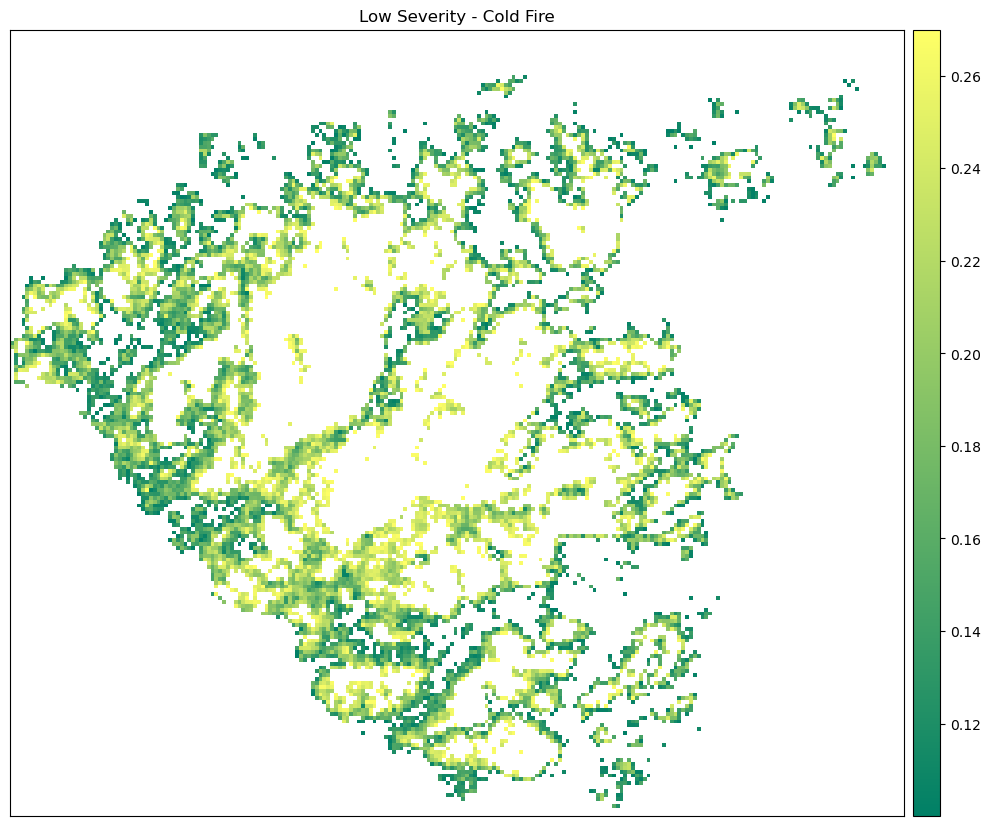

<Axes: title={'center': 'Low Severity - Cold Fire'}>

In [75]:
# low severity 0.1 - 0.27
valid_range = (0.1, 0.27)
if valid_range:
    mask = ((dnbr < valid_range[0]) | (dnbr >= valid_range[1]))
    low_sev = dnbr.where(~xr.where(mask, True, False))
    
# plot to verify
ep.plot_bands(low_sev,
              cmap='summer',
              title="Low Severity - Cold Fire")

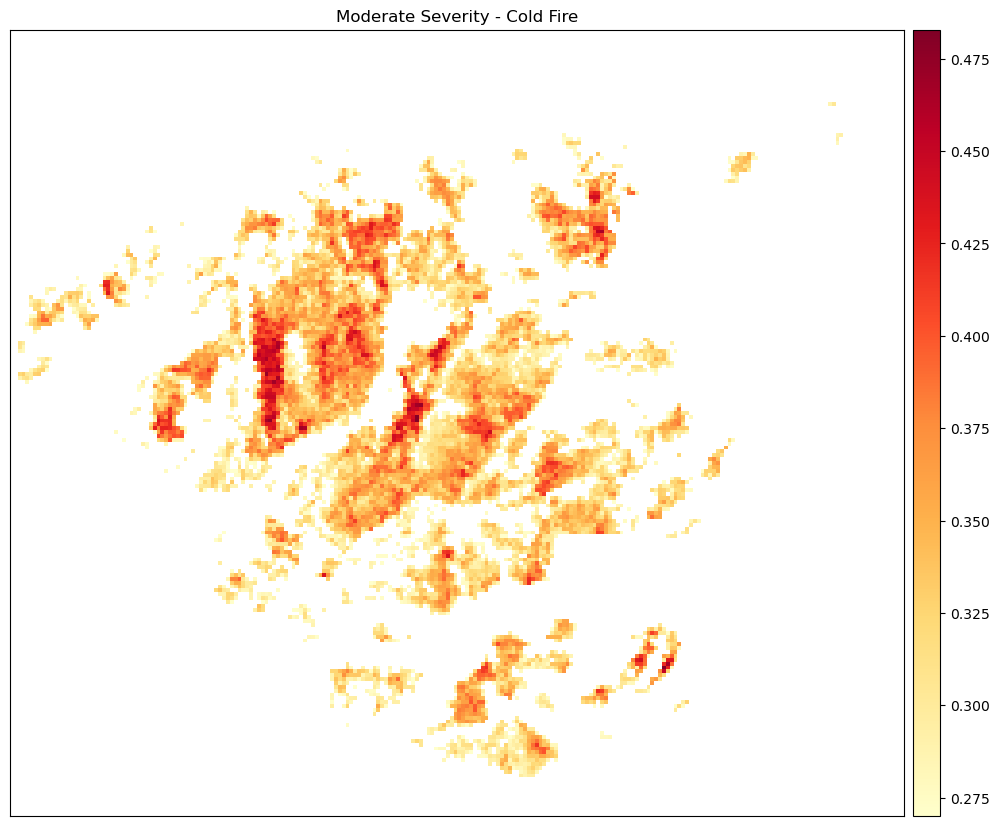

<Axes: title={'center': 'Moderate Severity - Cold Fire'}>

In [76]:
# mod-low & mod-high severity > 0.44
valid_range = (0.27, np.inf)
if valid_range:
    mask = ((dnbr < valid_range[0]))
    mod_sev = dnbr.where(~xr.where(mask, True, False))
    
# plot to verify
ep.plot_bands(mod_sev,
              cmap='YlOrRd',
              title="Moderate Severity - Cold Fire")

In [77]:
# create enhanced regrowth path
unburned_path = os.path.join(class_path, 'unburned.tif')
# create enhanced regrowth path
low_sev_path = os.path.join(class_path, 'low_sev.tif')
# create enhanced regrowth path
mod_sev_path = os.path.join(class_path, 'mod_sev.tif')

In [78]:
# export classified slope raster
unburned.rio.to_raster(unburned_path)
# export classified slope raster
low_sev.rio.to_raster(low_sev_path)
# export classified slope raster
mod_sev.rio.to_raster(mod_sev_path)

## Clip NDVI rasters using class rasters
To compare the relationship between vegetation regrowth and topography/burn severity using a linear least-squares regression, each NDVI raster needs to be clipped with each class raster created in the previous section.
### Acknowledgements
The code for clipping multiband rasters was adapted from a conversation with ChatGPT, a language model trained by OpenAI, on April 6, 2023. The code for sorting rasters was adapted from a ChatGPT conversation on April 11, 2023.

#### Folder and file paths

In [79]:
# folder path for all the clipped rasters
clip_ndvi_path = os.path.join(path, 'clipped_ndvi')
# folder path for stacked rasters
stack_class_path = os.path.join(path, 'stack_class')

In [80]:
# create folder for all the clipped rasters
os.mkdir(clip_ndvi_path)
# create folder for stacked rasters
os.mkdir(stack_class_path)

#### Function to clip multiband raster with a single band raster

In [81]:
"""
Function: Clip multiband raster with single-band raster. The filename of the
multiband raster will be used to name the clipped rasters.

Inputs:
mb_rst - file path of multiband raster
clip_rst_fldr - folder path of clip
clip_rst - filname of raster used to clip
clip_out_path - output folder path, a folder will be created in that folder
for the output rasters

Outputs: None. A single-band raster is saved for each band of the multiband
raster.
"""
def clip_mb_rst_w_rst(mb_rst, clip_rst_fldr, clip_rst, clip_out_path):
    # get filename without extension for creating folder & naming rasters
    fname = clip_rst[:-4]

    # create folder path for the rasters
    out_folder = os.path.join(clip_out_path, fname)
    
    if not os.path.isdir(out_folder):
        # create folder for rasters
        os.mkdir(out_folder)
    
    # change working directory to new folder
    os.chdir(out_folder)
    
    # open the input multiband raster file
    with rasterio.open(mb_rst) as src:
        # open the clip single band raster file
        with rasterio.open(os.path.join(clip_rst_fldr, clip_rst)) as clip_src:
            # define the window to use for clipping
            clip_window = clip_src.window(*src.bounds)

            # read the clip raster
            clip_data = clip_src.read(1, window=clip_window)

            # clip each band in the multiband raster
            for band_idx in range(1, src.count+1):

                # define the window for the current band
                window = src.window(*src.bounds)

                # read the input raster data for the current band and window
                input_data = src.read(band_idx, window=window)

                # clip the input raster data using the clip raster data
                clipped_data = np.where(clip_data >= np.nanmin(clip_data), 
                                        input_data, np.nan)

                # update the metadata for the output raster
                out_meta = src.meta.copy()
                out_meta.update({
                    'count': 1,
                    'height': clipped_data.shape[0],
                    'width': clipped_data.shape[1],
                    'transform': src.window_transform(window)
                })

                # export the clipped raster
                with rasterio.open(os.path.join(out_folder, f'{fname}_{band_idx}.tif'), 'w', **out_meta) as out:
                    out.write(clipped_data.astype(out_meta['dtype']), 1)        

#### Function to sort and stack rasters

In [82]:
"""
Function: Stack single-band rasters to create a multiband raster. The filename
of the one raster will be used to name the stack.

Inputs:
input_folder: folder containing single-band rasters
output_folder: folder to export multiband raster to

Outputs: None. A multiband raster is saved for each folder of single-band
rasters.
"""
def stack_rasters(input_folder, output_folder):
    # change working directory
    os.chdir(input_folder)
    
    # get list of rasters
    clip_rsts = glob.glob('*.tif')
    
    # sort rasters
    # Define a function to extract the numerical value from the filename
    def extract_number(filename):
        return int(''.join(filter(str.isdigit, os.path.splitext(filename)[0])))

    # Sort the filenames based on the numerical value
    sorted_rsts = sorted(clip_rsts, key=extract_number)
    
    # create name for stack
    stack_name = os.path.join(output_folder, sorted_rsts[0][:-6])
    
    # stack and save rasters
    # read metadata of first file
    with rasterio.open(sorted_rsts[0]) as src0:
        meta = src0.meta

    # update meta to reflect the number of rasters
    meta.update(count = len(sorted_rsts))

    # read each raster and write it to stack
    with rasterio.open(f'{stack_name}_stack.tif', 'w', **meta) as dst:
        for id, layer in enumerate(sorted_rsts, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

#### Clip and stack rasters

In [83]:
# get list of rasters in classification folder
os.chdir(class_path)
class_rsts = glob.glob('*.tif')

print(class_rsts)

['low_sev.tif', 'mild_slope.tif', 'mod_sev.tif', 'mod_slope.tif', 'north_aspect.tif', 'south_aspect.tif', 'steep_slope.tif', 'unburned.tif']


In [84]:
# loop through class raster and use them to clip NDVI stack
for rst in class_rsts:
    clip_mb_rst_w_rst(ndvi_stack_path, class_path, rst, clip_ndvi_path)

In [85]:
# get list of folders from clipped_ndvi
folders = os.listdir(clip_ndvi_path)

print(folders)

['low_sev', 'mild_slope', 'mod_sev', 'mod_slope', 'north_aspect', 'south_aspect', 'steep_slope', 'unburned']


In [86]:
for folder in folders:
    stack_rasters(os.path.join(clip_ndvi_path, folder), stack_class_path)

<div class="alert alert-block alert-warning">To verify everything clipped properly, let's check to make sure the raster shapes are the same.</div>

In [87]:
# get list of explanatory rasters
os.chdir(class_path)
x_rasters = glob.glob('*.tif')
print(x_rasters)

['low_sev.tif', 'mild_slope.tif', 'mod_sev.tif', 'mod_slope.tif', 'north_aspect.tif', 'south_aspect.tif', 'steep_slope.tif', 'unburned.tif']


In [88]:
# check to see if we have the same number of raster and folders
print(len(x_rasters), len(folders))

8 8


In [89]:
# make sure both lists are in the same order
# this can be done visually too since there's only 8 items
for i in range(len(x_rasters)):
    x = x_rasters[i][:-4]
    y = folders[i]
    
    print(x == y)

True
True
True
True
True
True
True
True


#### Function to open raster, get a band, and get it ready for analysis

In [90]:
def clean_rst_band(in_rst, band):
    # get band
    in_rst_band = np.array(in_rst.GetRasterBand(band).ReadAsArray())

    # flatten the array
    rst_band_flat = in_rst_band.flatten()

    # remove nan values
    rst_band_clean = rst_band_flat[~np.isnan(rst_band_flat)]
    
    return rst_band_clean

In [91]:
# check to see if x and y rasters are the same shape
for i in range(len(x_rasters)):
    x_rst = gdal.Open(os.path.join(class_path, x_rasters[i]))
    x_var = clean_rst_band(x_rst, 1)
    
    name = x_rasters[i][:-4]
    
    print(f'{name} x: {x_var.shape}')
    
    os.chdir(os.path.join(clip_ndvi_path, folders[i]))
    y_rsts = glob.glob('*.tif')
        
    for rst in y_rsts:
        y_rst = gdal.Open(os.path.join(clip_ndvi_path, folders[i], rst))
        y_var = clean_rst_band(y_rst, 1)

        print(f'y: {y_var.shape}')

low_sev x: (9064,)
y: (9064,)
y: (9064,)
y: (9064,)
y: (9064,)
y: (9064,)
y: (9064,)
y: (9064,)
y: (9064,)
y: (9064,)
y: (9064,)
y: (9064,)
y: (9064,)
y: (9064,)
y: (9064,)
y: (9064,)
mild_slope x: (3429,)
y: (3429,)
y: (3429,)
y: (3429,)
y: (3429,)
y: (3429,)
y: (3429,)
y: (3429,)
y: (3429,)
y: (3429,)
y: (3429,)
y: (3429,)
y: (3429,)
y: (3429,)
y: (3429,)
y: (3429,)
mod_sev x: (8257,)
y: (8257,)
y: (8257,)
y: (8257,)
y: (8257,)
y: (8257,)
y: (8257,)
y: (8257,)
y: (8257,)
y: (8257,)
y: (8257,)
y: (8257,)
y: (8257,)
y: (8257,)
y: (8257,)
y: (8257,)
mod_slope x: (14208,)
y: (14208,)
y: (14208,)
y: (14208,)
y: (14208,)
y: (14208,)
y: (14208,)
y: (14208,)
y: (14208,)
y: (14208,)
y: (14208,)
y: (14208,)
y: (14208,)
y: (14208,)
y: (14208,)
y: (14208,)
north_aspect x: (5400,)
y: (5400,)
y: (5400,)
y: (5400,)
y: (5400,)
y: (5400,)
y: (5400,)
y: (5400,)
y: (5400,)
y: (5400,)
y: (5400,)
y: (5400,)
y: (5400,)
y: (5400,)
y: (5400,)
y: (5400,)
south_aspect x: (7748,)
y: (7748,)
y: (7748,)
y: (7748

<div class="alert alert-block alert-success">
    Success!
</div>

## Perform linear regression analysis using scipy

Now that all the data preprocessing is done, it's time to analyze the data! NDVI post-fire is the dependent/response variable, and independent/explanatory variables will be pre-fire NDVI for the following classes:
* Entire burn scar
* Slope
    + Mild
    + Moderate
    + Steep
* Aspect
    + North-facing
    + South-facing
* Burn severity level
    + Regrowth
    + Unburned
    + Low severity
    + Mod-low severity
    + Mod-high severity

#### Function to save scatter plot of data

In [92]:

def save_plot(title, df, out_path):
    # create plot
    line_plt = df.plot(x='Year', y='R-squared', title=title).get_figure()
    
    # save plot
    line_plt.savefig(out_path)

#### Function to perform linear regression, save plots, and save stats as csv

In [93]:
"""
Function: Perform linear regression using a raster stack and save stats for each year in a dataframe that is exported as a 
CSV, as well as export a CSV with R-squared from all years. Additionally, a line plot of R-squared is created and saved.

Inputs:
rst_path: path to raster stack
year: first year for the series of regressions (2012 is skipped)
title_dict: dictionary of titles for the line plots
out_path: output path to save the files

Outputs: None.
"""
def lin_reg(rst_path, year, title_dict, out_path):
    # open independent raster
    rst = gdal.Open(rst_path)
    
    # independent variable is the first band, pre-fire 2008
    x_var = clean_rst_band(rst, 1)
    
    # create a data frame with column names for our stats
    stats_df = pd.DataFrame(columns = ['Year', 
                                       'Slope', 
                                       'Intercept', 
                                       'R-value', 
                                       'P-value', 
                                       'Std_Err', 
                                       'R-squared'])
    
    # create folder for plots and for CSVs
    img_path = os.path.join(out_path, 'images')
    if not os.path.exists(img_path):
        os.mkdir(img_path)
    
    stats_path = os.path.join(out_path, 'stats')
    if not os.path.exists(stats_path):
        os.mkdir(stats_path)
    
    # the rest of the bands are the dependent variable
    for i in range(2, rst.RasterCount + 1):
        # get raster band
        y_var = clean_rst_band(rst, i)
    
        # run regression analysis
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            x_var, y_var)
        
        # calculate r-squared
        r_squared = r_value**2
        
        # add stats to df
        stats_df.loc[len(stats_df.index)] = [year, 
                                             slope, 
                                             intercept, 
                                             r_value, 
                                             p_value, 
                                             std_err, 
                                             r_squared]
        # increment year but skip 2012
        year += 1

        if year == 2012:
            year += 1

    # get filename to use for naming outputs
    fname = os.path.basename(os.path.normpath(rst_path))

    if fname == 'ndvi_stack.tif':
        name = 'ndvi'
    else:
        name = fname[:-10]

    # create and save plot
    save_plot(title_dict[fname], 
              stats_df, 
              os.path.join(img_path, f'{name}.png'))

    # save stats as csv
    stats_df.to_csv(os.path.join(stats_path, f'{name}.csv'))

#### Function to put all R-squared's in one df and export as csv

In [94]:
# create a function to put all R-squared's in one df and export
def get_r_sq(input_path, output_path):
    # change working directory
    os.chdir(input_path)
    
    # get list CSVs
    csvs = glob.glob('*.csv')
    
    # go through all CSVs
    for csv in csvs:
        # read the CSV
        in_df = pd.read_csv(os.path.join(input_path, csv))
        
        # with the first CSV
        if csv == csvs[0]:
            # create a new dataframe with 'Year' column
            rsq_df = in_df[['Year']]
            
        # create new column name from filename
        col_name = csv[:-4]
        
        # get r-squared column
        rsq_df = rsq_df.join(in_df['R-squared'])
        
        # replace column name
        rsq_df = rsq_df.rename(columns ={'R-squared': col_name})
        
    # save df as CSV
    rsq_df.to_csv(os.path.join(output_path, 'r_squared.csv'))
    
    return rsq_df

#### Create output path and plot title dictionary

In [95]:
# create a dictionary that uses filenames to look up plot title
titles = {
    'low_sev_stack.tif': 'Low-Severity Burn Level, dNBR 0.1 - 0.27',
    'mild_slope_stack.tif': 'Mild Slope, 0 - 8%',
    'mod_sev_stack.tif': 'Moderate-Severity Burn Level, dNBR > 0.27',
    'mod_slope_stack.tif': 'Moderate Slope, 8 - 30%',
    'north_aspect_stack.tif': 'North-Facing Slopes',
    'unburned_stack.tif': 'Regrowth & Unburned Burn Level dNBR < 0.1',
    'south_aspect_stack.tif': 'South-Facicng Slopes',
    'steep_slope_stack.tif': 'Steep Slope, > 30%',
    'ndvi_stack.tif': 'Entire Burn Scar'
}

In [96]:
# create path for an analysis folder
analysis_path = os.path.join(path, 'analysis')
# create path for linear regression outputs
lin_reg_path = os.path.join(analysis_path,'lin_reg')

In [98]:
# create analysis folder
os.mkdir(analysis_path)
# create linear regression folder
os.mkdir(lin_reg_path)

### Linear regression

In [99]:
# get list of response rasters
os.chdir(stack_class_path)
class_rsts = glob.glob('*.tif')
print(class_rsts)

['low_sev_stack.tif', 'mild_slope_stack.tif', 'mod_sev_stack.tif', 'mod_slope_stack.tif', 'north_aspect_stack.tif', 'south_aspect_stack.tif', 'steep_slope_stack.tif', 'unburned_stack.tif']


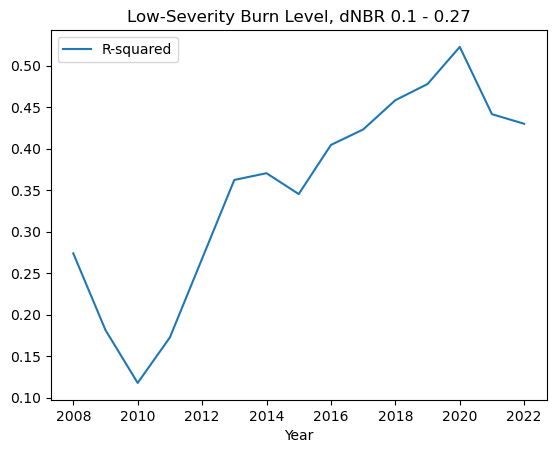

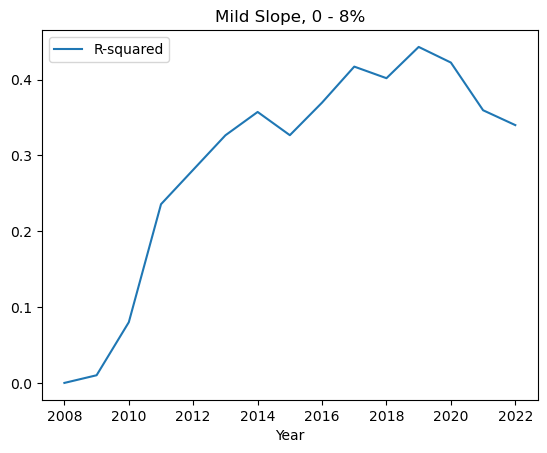

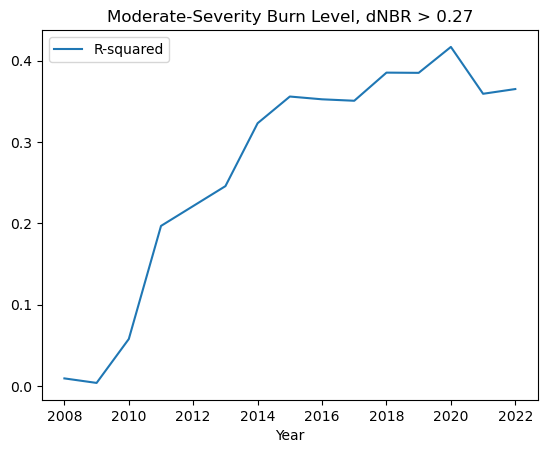

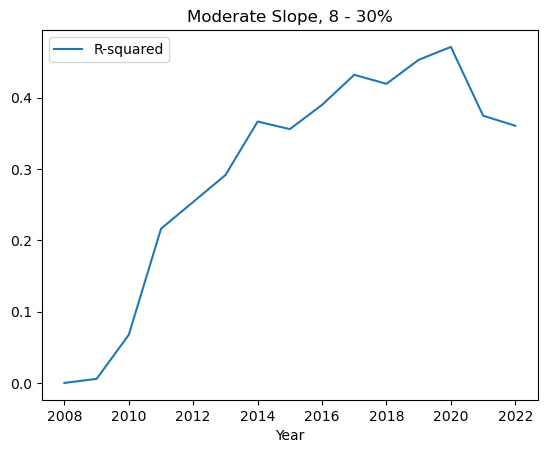

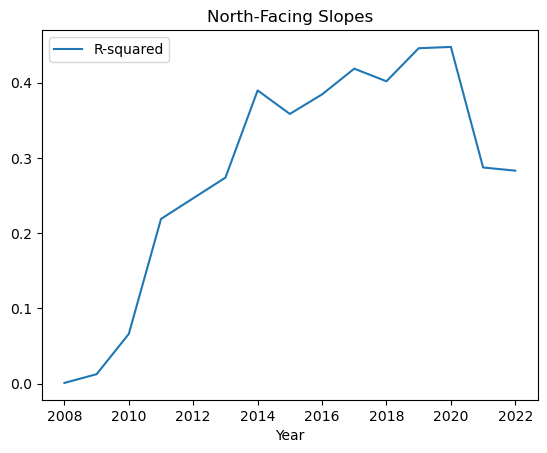

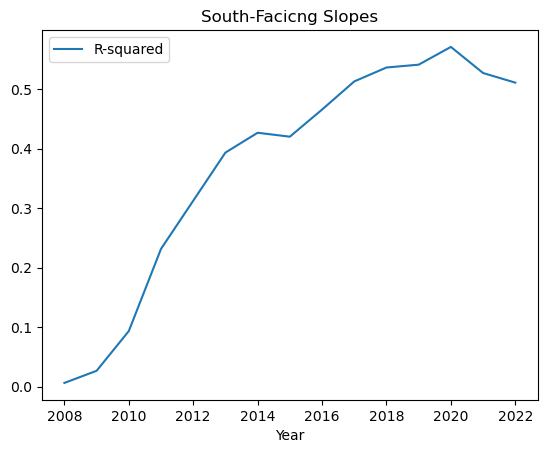

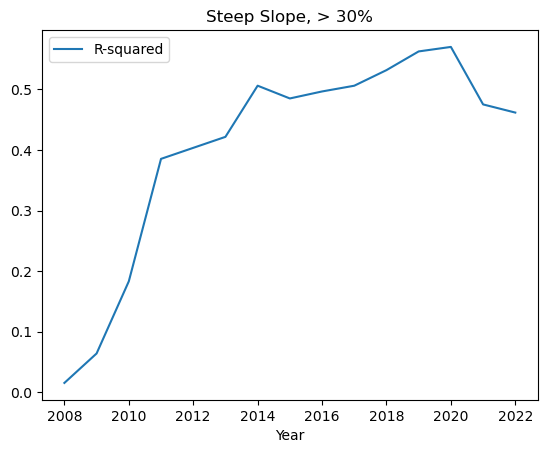

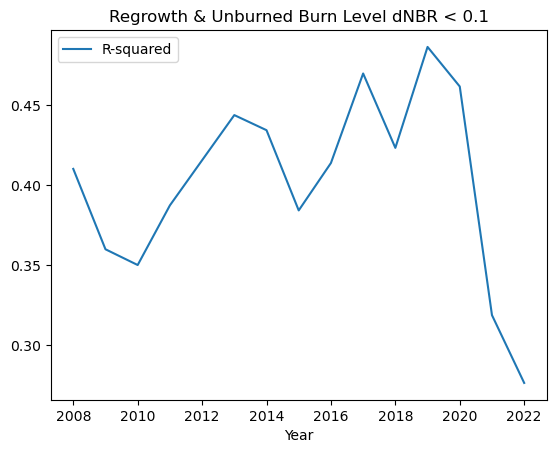

In [100]:
# linear regression for classes from previous section
for rst in class_rsts:
    lin_reg(os.path.join(stack_class_path, rst), 
            2008, 
            titles, 
            lin_reg_path)

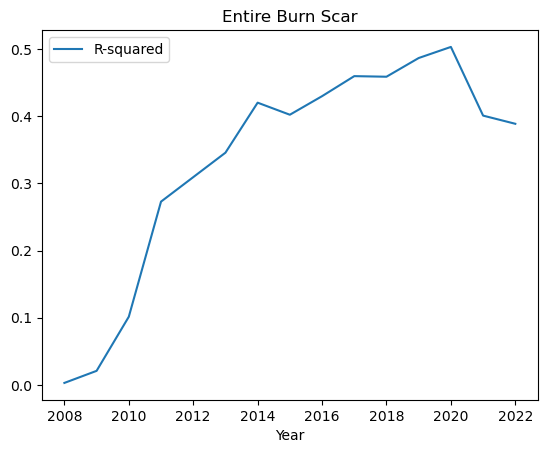

In [101]:
# linear regression for entire burn scar
lin_reg(ndvi_stack_path, 
            2008, 
            titles, 
            lin_reg_path)

In [102]:
# get all the R-squared's
rs_df = get_r_sq(os.path.join(lin_reg_path, 'stats'), lin_reg_path)

#### Look at some plots!

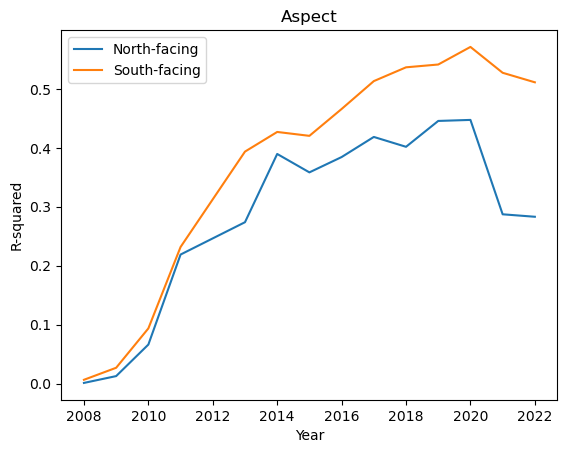

In [103]:
plt.plot(rs_df['Year'], rs_df['north_aspect'], label='North-facing')
plt.plot(rs_df['Year'], rs_df['south_aspect'], label='South-facing')
plt.title('Aspect')
plt.xlabel('Year')
plt.ylabel('R-squared')
plt.legend()
plt.show()

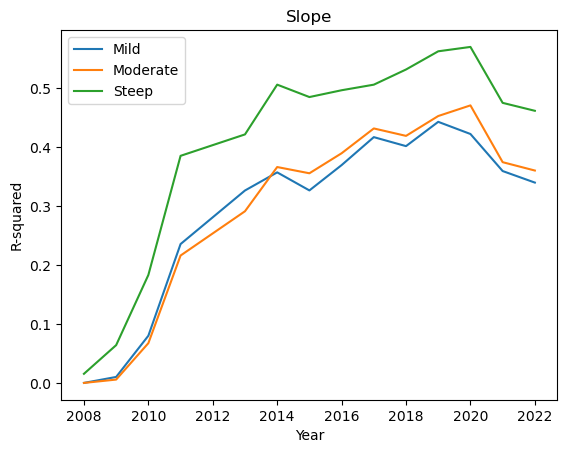

In [104]:
plt.plot(rs_df['Year'], rs_df['mild_slope'], label='Mild')
plt.plot(rs_df['Year'], rs_df['mod_slope'], label='Moderate')
plt.plot(rs_df['Year'], rs_df['steep_slope'], label='Steep')
plt.title('Slope')
plt.xlabel('Year')
plt.ylabel('R-squared')
plt.legend()
plt.show()

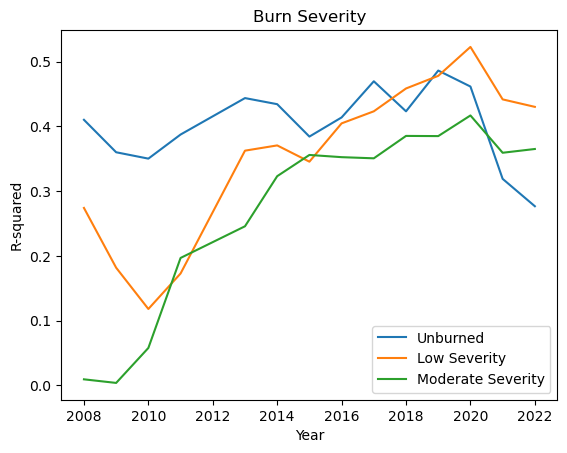

In [105]:
plt.plot(rs_df['Year'], rs_df['unburned'], label='Unburned')
plt.plot(rs_df['Year'], rs_df['low_sev'], label='Low Severity')
plt.plot(rs_df['Year'], rs_df['mod_sev'], label='Moderate Severity')
plt.title('Burn Severity')
plt.xlabel('Year')
plt.ylabel('R-squared')
plt.legend()
plt.show()

### Random forest regression
The models weren't too accurate, but it was fun to try

In [148]:
# open the explanatory variables
dnbr = clean_rst_band(gdal.Open(dnbr_path), 1)
slope = clean_rst_band(gdal.Open(slope_mask_path), 1)
north = clean_rst_band(gdal.Open(north_clip_path), 1)
east = clean_rst_band(gdal.Open(east_clip_path), 1)

# verify they're all the same shape
print(dnbr.shape)
print(slope.shape)
print(north.shape)
print(east.shape)

(25637,)
(25637,)
(25637,)
(25637,)


In [150]:
# create dataframe with all the explanatory data
X_df = pd.DataFrame({'dnbr': dnbr, 
                     'slope': slope, 
                     'north': north, 
                     'east': east})

In [151]:
# create dataframe with the response variables

# only want data from 2009 and on, not the year of the fire
year = 2009
# create empty datafram
y_df = pd.DataFrame()
# open NDVI stack
ndvi_rst = gdal.Open(ndvi_stack_path)
# get the data from the rasters and put it in the datafram
for i in range(3, ndvi_rst.RasterCount + 1):
        # get raster band
        ndvi = clean_rst_band(ndvi_rst, i)
        
        # add to df
        y_df[f'NDVI_{str(year)}'] = ndvi
        
        # increment year but skip 2012
        year += 1

        if year == 2012:
            year += 1

In [152]:
# verify NDVI df is the same shape as the explanatory df
y_df.shape

(25637, 13)

In [153]:
# split up the data between training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_df, test_size=0.4, random_state=0)

In [156]:
# scale data, otherwise model will fail
# standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler().fit(X_train)

# no longer a df, now numpy array
X_scaled = scaler.transform(X_df)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = scaler.transform(X_train)

In [159]:
# perform random forest regression
for col in y_df:
    
    # train the model with training data
    model = RandomForestRegressor(n_estimators = 150, random_state=42)
    model.fit(X_train_scaled, y_train[col])
    
    # show R-squared using test data on the model
    print(f'{col}\nR-squared: {model.score(X_test_scaled, y_test[col])}')
    
    # cross validation accuracy assessment
    scores = cross_val_score(model, X_scaled, y_df[col], cv=5)
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    
    # show important features
    feature_list = list(X_df.columns)
    feature_imp = pd.Series(model.feature_importances_, index=feature_list).sort_values(ascending=False)
    print(f'feature importances \n{feature_imp}\n')

NDVI_2009
R-squared: 0.5598944978974751
0.24 accuracy with a standard deviation of 0.33
feature importances 
dnbr     0.653371
slope    0.140563
east     0.110438
north    0.095629
dtype: float64

NDVI_2010
R-squared: 0.2759017192501795
-0.11 accuracy with a standard deviation of 0.30
feature importances 
dnbr     0.447234
slope    0.229558
east     0.164271
north    0.158938
dtype: float64

NDVI_2011
R-squared: 0.25330513274107935
-0.22 accuracy with a standard deviation of 0.28
feature importances 
dnbr     0.402959
slope    0.248005
north    0.179807
east     0.169229
dtype: float64

NDVI_2013
R-squared: 0.22131967413871434
-0.15 accuracy with a standard deviation of 0.23
feature importances 
dnbr     0.376466
slope    0.261158
north    0.205860
east     0.156515
dtype: float64

NDVI_2014
R-squared: 0.28152362723881585
-0.06 accuracy with a standard deviation of 0.24
feature importances 
dnbr     0.391434
slope    0.249585
north    0.194933
east     0.164048
dtype: float64

NDVI_201

[Return to top](#top)